In [174]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [175]:
%matplotlib inline


In [176]:
df = pd.read_csv('merge_train.csv',parse_dates=['date'])

In [177]:
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekdays'] = df['date'].dt.dayofweek  # 1 for weekend, 0 for weekday
df['hour'] = df['date'].dt.hour
df['minute'] = df['date'].dt.minute
# df['EMA_4h'] = df['Price'].ewm(span=48, adjust=False).mean()


df['SMA_4h'] = df['Price'].shift(1).rolling(window=48).mean()

df['SMA_1h'] = df['Price'].shift(1).rolling(window=12).mean()

df['SMA_30min'] = df['Price'].shift(1).rolling(window=6).mean()


df['SMA_2h'] = df['Price'].shift(1).rolling(window=24).mean()


df["Dmemand_diff"] = df["Demand"] - df["Actual_Demand_OPERATIONAL_DEMAND"]
# df['EMA_1d'] = df['Price'].ewm(span=288, adjust=False).mean()

df.set_index('date', inplace=True)

In [178]:

def mark_peak_hours(hour):
    if (8 <= hour < 10) or (15 <= hour < 17):
        return 1 
    else:
        return 0  


df['is_peak_hour'] = df['hour'].apply(mark_peak_hours)


In [179]:

df = df.drop(columns=['Region', 'Actual_Roof_OPOWER', 'Actual_Roof_LASTCHANGED','Adjusted_Actual_Roof_OPOWER'])
# df = df.drop(df.columns[df.columns.str.contains('forecast', case=False)], axis=1)



In [180]:
df.columns


Index(['Demand', 'Price', 'Actual_Demand_OPERATIONAL_DEMAND', 'month', 'day',
       'weekdays', 'hour', 'minute', 'SMA_4h', 'SMA_1h', 'SMA_30min', 'SMA_2h',
       'Dmemand_diff', 'is_peak_hour'],
      dtype='object')

In [181]:
from datetime import datetime, time

def create_qld_holidays_list():
    holidays = [
        # 2023
        "2023-01-01", "2023-01-02", "2023-01-26", "2023-04-07", "2023-04-08", "2023-04-09", "2023-04-10",
        "2023-04-25", "2023-05-01", "2023-08-16", "2023-10-02", "2023-12-25", "2023-12-26",
        # 2024
        "2024-01-01", "2024-01-26", "2024-03-29", "2024-03-30", "2024-03-31", "2024-04-01",
        "2024-04-25", "2024-05-06", "2024-08-14", "2024-10-07", "2024-12-25", "2024-12-26",
        # 2025
        "2025-01-01", "2025-01-27", "2025-04-18", "2025-04-19", "2025-04-20", "2025-04-21",
        "2025-04-25", "2025-05-05", "2025-08-13", "2025-10-06", "2025-12-25", "2025-12-26"
    ]
    return pd.to_datetime(holidays)

def add_qld_holidays(df):
    holidays = create_qld_holidays_list()
    
   
    df['is_holiday'] = 0
    
    df.loc[df.index.isin(holidays), 'is_holiday'] = 1
    
    
    return df

In [182]:
df = add_qld_holidays(df)

In [183]:
df.columns

Index(['Demand', 'Price', 'Actual_Demand_OPERATIONAL_DEMAND', 'month', 'day',
       'weekdays', 'hour', 'minute', 'SMA_4h', 'SMA_1h', 'SMA_30min', 'SMA_2h',
       'Dmemand_diff', 'is_peak_hour', 'is_holiday'],
      dtype='object')

In [184]:
df

,Demand,Price,Actual_Demand_OPERATIONAL_DEMAND,month,day,weekdays,hour,minute,SMA_4h,SMA_1h,SMA_30min,SMA_2h,Dmemand_diff,is_peak_hour,is_holiday
date,,,,,,,,,,,,,,,
2023-07-23 00:00:00,5988.16,75.93,6057.0,7,23,6,0,0,NaN,NaN,NaN,NaN,-68.84,0,0
2023-07-23 00:05:00,6002.58,151.76,6057.0,7,23,6,0,5,NaN,NaN,NaN,NaN,-54.42,0,0
2023-07-23 00:10:00,5918.29,95.11,6057.0,7,23,6,0,10,NaN,NaN,NaN,NaN,-138.71,0,0
2023-07-23 00:15:00,5930.99,95.74,6057.0,7,23,6,0,15,NaN,NaN,NaN,NaN,-126.01,0,0
2023-07-23 00:20:00,5836.53,94.39,6057.0,7,23,6,0,20,NaN,NaN,NaN,NaN,-220.47,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-03 22:40:00,6382.92,284.95,6698.0,8,3,5,22,40,279.830000,257.741667,284.983333,264.400417,-315.08,0,0
2024-08-03 22:45:00,6378.81,284.97,6698.0,8,3,5,22,45,279.629375,261.908333,284.671667,264.131250,-319.19,0,0
2024-08-03 22:50:00,6403.51,228.01,6698.0,8,3,5,22,50,279.352500,262.394167,283.460000,263.902083,-294.49,0,0


In [185]:
df['Demand_lag'] = df['Demand'].shift(1)  
df['Actual_Demand_OPERATIONAL_DEMAND_lag'] = df['Actual_Demand_OPERATIONAL_DEMAND'].shift(1)
df.drop(columns=['Demand', 'Actual_Demand_OPERATIONAL_DEMAND'], inplace=True)
df['last_price'] = df['Price'].shift(1)
df['rolling_max_price'] = df['last_price'].rolling(window=24).max()
df['rolling_min_price'] = df['last_price'].rolling(window=24).min()

df['peak_hour_demand_lag'] = df['is_peak_hour'] * df['Demand_lag']
df['near_max'] = df['last_price'] > (df['rolling_max_price'] * 0.9)
df['near_min'] = df['last_price'] < (df['rolling_min_price'] * 1.1)

df.dropna(inplace=True)

In [186]:
df.columns

Index(['Price', 'month', 'day', 'weekdays', 'hour', 'minute', 'SMA_4h',
       'SMA_1h', 'SMA_30min', 'SMA_2h', 'Dmemand_diff', 'is_peak_hour',
       'is_holiday', 'Demand_lag', 'Actual_Demand_OPERATIONAL_DEMAND_lag',
       'last_price', 'rolling_max_price', 'rolling_min_price',
       'peak_hour_demand_lag', 'near_max', 'near_min'],
      dtype='object')

In [187]:
df

,Price,month,day,weekdays,hour,minute,SMA_4h,SMA_1h,SMA_30min,SMA_2h,...,is_peak_hour,is_holiday,Demand_lag,Actual_Demand_OPERATIONAL_DEMAND_lag,last_price,rolling_max_price,rolling_min_price,peak_hour_demand_lag,near_max,near_min
date,,,,,,,,,,,,,,,,,,,,,
2023-07-23 04:00:00,93.77,7,23,6,4,0,90.099167,87.681667,90.483333,91.851667,...,0,0,5411.77,5445.0,92.53,115.25,76.32,0.0,False,False
2023-07-23 04:05:00,99.09,7,23,6,4,5,90.470833,87.660833,90.583333,92.578750,...,0,0,5461.49,5441.0,93.77,115.25,78.43,0.0,False,False
2023-07-23 04:10:00,93.19,7,23,6,4,10,89.373542,89.139167,91.778333,92.809167,...,0,0,5471.60,5441.0,99.09,115.25,78.43,0.0,False,False
2023-07-23 04:15:00,94.41,7,23,6,4,15,89.333542,89.082500,94.016667,92.790000,...,0,0,5439.76,5441.0,93.19,115.25,78.43,0.0,False,False
2023-07-23 04:20:00,94.75,7,23,6,4,20,89.305833,90.170833,94.360000,92.822500,...,0,0,5510.68,5441.0,94.41,115.25,78.43,0.0,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-03 22:40:00,284.95,8,3,5,22,40,279.830000,257.741667,284.983333,264.400417,...,0,0,6467.61,6698.0,287.32,292.24,181.73,0.0,True,False
2024-08-03 22:45:00,284.97,8,3,5,22,45,279.629375,261.908333,284.671667,264.131250,...,0,0,6382.92,6698.0,284.95,292.24,181.73,0.0,True,False
2024-08-03 22:50:00,228.01,8,3,5,22,50,279.352500,262.394167,283.460000,263.902083,...,0,0,6378.81,6698.0,284.97,292.24,181.73,0.0,True,False


In [188]:
X = df.drop('Price', axis=1)
y = df['Price']

train_end_date = pd.to_datetime("2024-04-30 23:59:59")
val_end_date = pd.to_datetime("2024-05-31 23:59:59")
test_start_date = pd.to_datetime("2024-06-01 00:00:00")


X_train = X[X.index <= train_end_date]
X_val = X[(X.index > train_end_date) & (X.index <= val_end_date)]
X_test = X[X.index >= test_start_date]

y_train = y[y.index <= train_end_date]
y_val = y[(y.index > train_end_date) & (y.index <= val_end_date)]
y_test = y[y.index >= test_start_date]

In [189]:
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.metrics import root_mean_squared_error , mean_absolute_error
import random

class MultiLossXGBoostElectricityPriceEnsemble:
    def __init__(self, alpha: float = 0.5, beta: float = 0.3, gamma: float = 0.2, n_models: int = 3):
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_models = n_models
        self.models = []
        self.errors = []  # 用來記錄每個模型的誤差
        
    def custom_objective(self, preds: np.ndarray, dtrain: xgb.DMatrix, alpha: float, beta: float, gamma: float):
        labels = dtrain.get_label()
        
        grad_mse = preds - labels
        hess_mse = np.ones_like(preds)
        
        grad_mae = np.sign(preds - labels)
        hess_mae = np.ones_like(preds) * 1e-6
        
        delta = 1
        diff = preds - labels
        grad_huber = np.where(np.abs(diff) <= delta, diff, delta * np.sign(diff))
        hess_huber = np.where(np.abs(diff) <= delta, 1, 0)
        
        grad = alpha * grad_mse + beta * grad_mae + gamma * grad_huber
        hess = alpha * hess_mse + beta * hess_mae + gamma * hess_huber
        
        return grad, hess

    def custom_metric(self, preds: np.ndarray, dtrain: xgb.DMatrix):
        labels = dtrain.get_label()
        
        rmse = root_mean_squared_error (labels, preds)  # RMSE
        mae = mean_absolute_error(labels, preds)
        huber = np.mean(np.where(np.abs(preds - labels) <= 5, 
                                 0.5 * (preds - labels)**2, 
                                 np.abs(preds - labels) - 0.5))
        
        combined_metric = self.alpha * rmse + self.beta * mae + self.gamma * huber
        
        return 'combined_metric', combined_metric
    
    def randomize_params(self, seed=42):
        random.seed(seed)
        params = {
            'objective': 'reg:squarederror',
            'max_depth': random.choice([10, 11, 12]),
            'learning_rate': random.uniform(0.01, 0.03),
            'min_child_weight': random.uniform(0.6, 1.0),
            'lambda': random.uniform(0.8, 1.0),
            'random_state': random.randint(0, 1000)
        }
        return params
    
    def train(self, X_train: pd.DataFrame, y_train: pd.Series, X_val: pd.DataFrame, y_val: pd.Series):
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dval = xgb.DMatrix(X_val, label=y_val)
        
        for i in range(self.n_models):
            print(f"Training model {i+1}/{self.n_models}...")
            
            # 隨機化 alpha, beta, gamma
            r_alpha = self.alpha + random.uniform(-0.1, 0.1)
            r_beta = self.beta + random.uniform(-0.1, 0.1)
            r_gamma = self.gamma + random.uniform(-0.1, 0.1)
            
            params = self.randomize_params(seed=i)
            
            # 自定義目標函數，使用 partial 來傳遞 alpha, beta, gamma
            def obj_wrapper(preds, dtrain):
                return self.custom_objective(preds, dtrain, r_alpha, r_beta, r_gamma)
            
            model = xgb.train(
                params,
                dtrain,
                num_boost_round=1000,
                evals=[(dtrain, 'train'), (dval, 'val')],
                obj=obj_wrapper,
                custom_metric=self.custom_metric,
                early_stopping_rounds=50,
                verbose_eval=100
            )
            
            val_preds = model.predict(dval)
            val_error = root_mean_squared_error (y_val, val_preds)  # RMSE
            self.errors.append(val_error)
            self.models.append(model)
    
    def predict(self, X_test: pd.DataFrame) -> np.ndarray:
        dtest = xgb.DMatrix(X_test)
        predictions = np.zeros(X_test.shape[0])
        
        error_weights = np.array(self.errors)
        weights = 1 / (error_weights + 1e-6)  
        weights = weights / np.sum(weights)  
        
        for model, weight in zip(self.models, weights):
            predictions += model.predict(dtest) * weight
        
        return predictions


In [190]:


ensemble_model = MultiLossXGBoostElectricityPriceEnsemble(alpha=0.3, beta=0.5, gamma=0.2, n_models=6)


ensemble_model.train(X_train, y_train, X_val, y_val)

predictions = ensemble_model.predict(X_test)


Training model 1/6...
[0]	train-rmse:402.96656	train-combined_metric:184.33763	val-rmse:122.71684	val-combined_metric:106.64712
[100]	train-rmse:154.22399	train-combined_metric:58.79903	val-rmse:41.75659	val-combined_metric:25.68822
[191]	train-rmse:90.21320	train-combined_metric:37.17575	val-rmse:43.44139	val-combined_metric:25.35850
Training model 2/6...
[0]	train-rmse:403.97411	train-combined_metric:184.86750	val-rmse:123.14869	val-combined_metric:107.03470
[100]	train-rmse:186.12907	train-combined_metric:70.50731	val-rmse:42.25300	val-combined_metric:26.94380
[200]	train-rmse:122.59191	train-combined_metric:48.48121	val-rmse:41.60739	val-combined_metric:24.93080
[209]	train-rmse:118.65923	train-combined_metric:47.18911	val-rmse:42.06927	val-combined_metric:25.10768
Training model 3/6...
[0]	train-rmse:406.03636	train-combined_metric:186.09993	val-rmse:124.30561	val-combined_metric:108.06682
[100]	train-rmse:239.74355	train-combined_metric:95.09554	val-rmse:49.96551	val-combined_met

In [191]:

predictions = ensemble_model.predict(X_test)

In [192]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mse)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")

Mean Squared Error: 72886.69377144221
Mean Absolute Error: 37.99352141797026
Root Mean Squared Error: 269.97535771148114


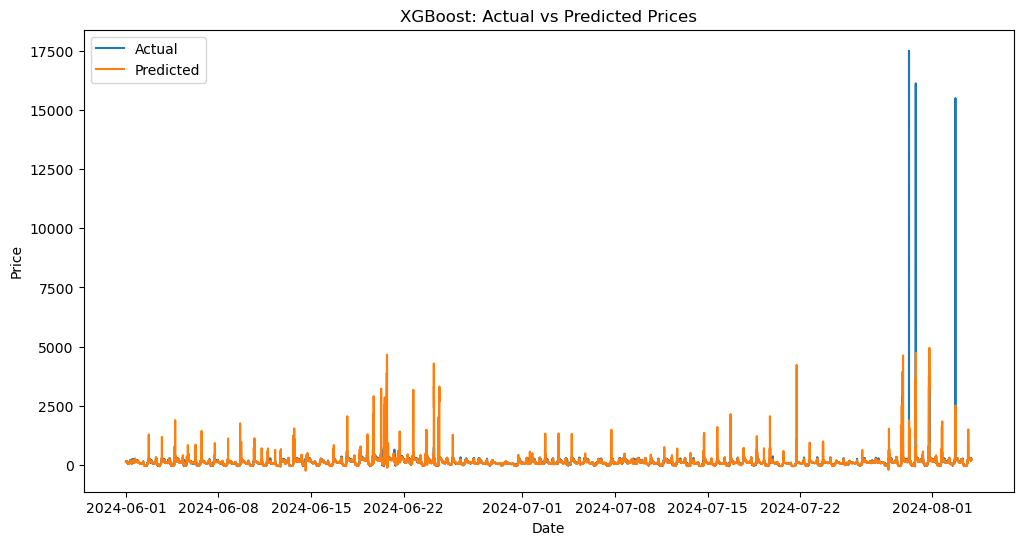

In [193]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, predictions, label='Predicted')
plt.title('XGBoost: Actual vs Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

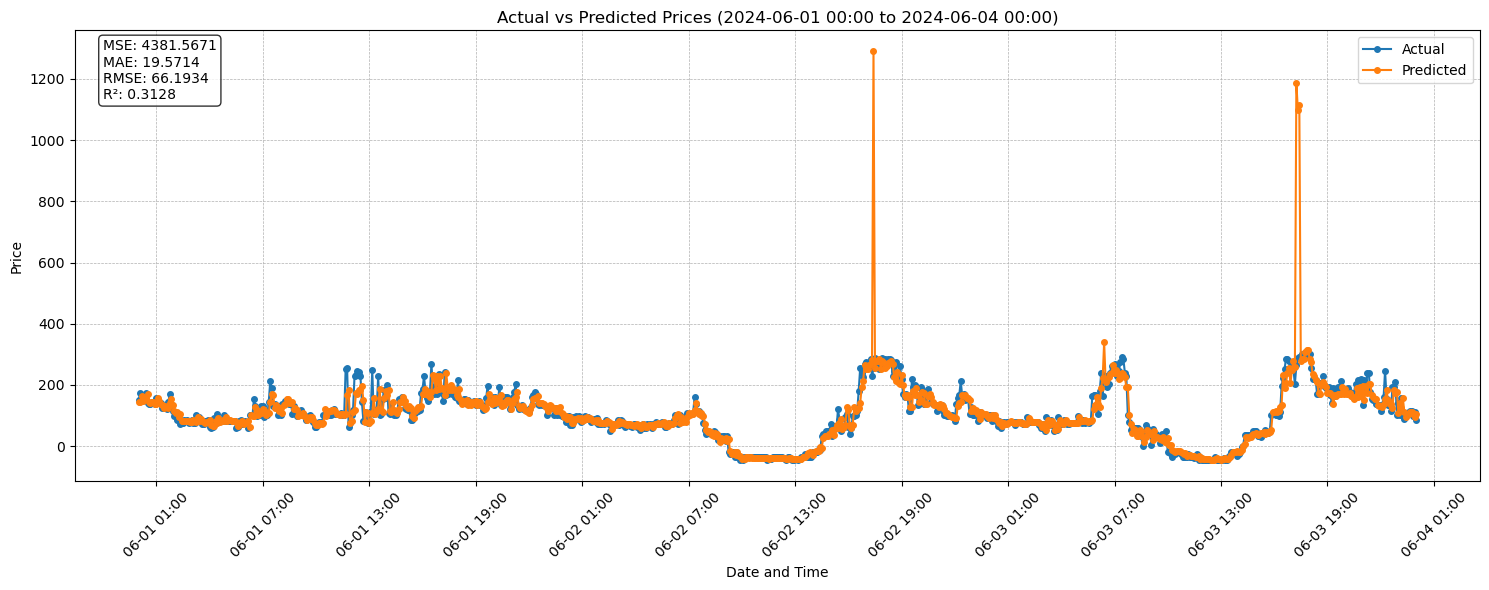

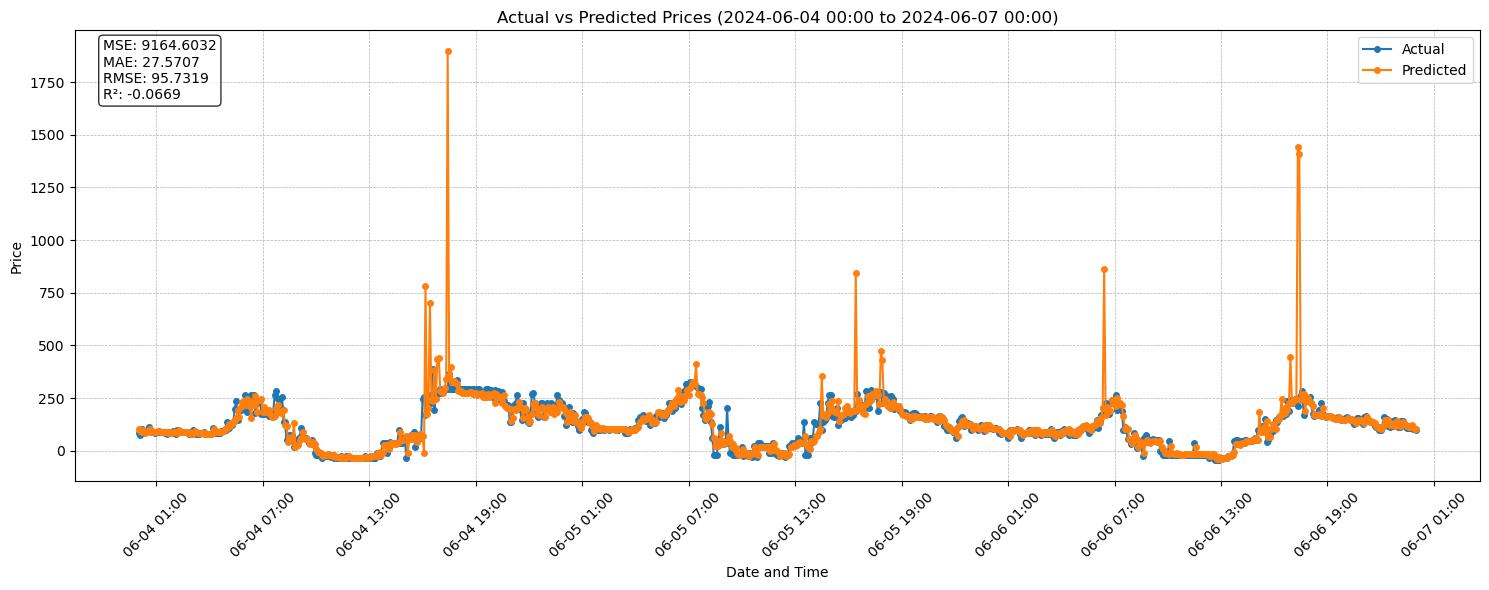

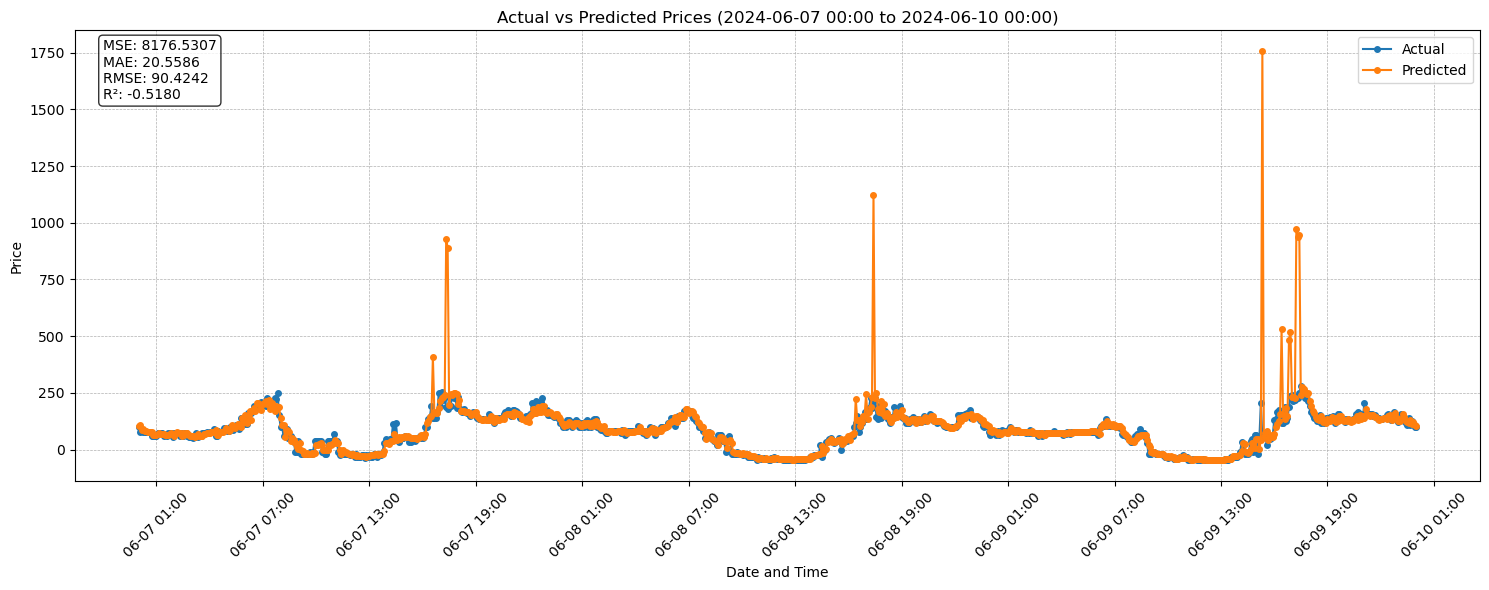

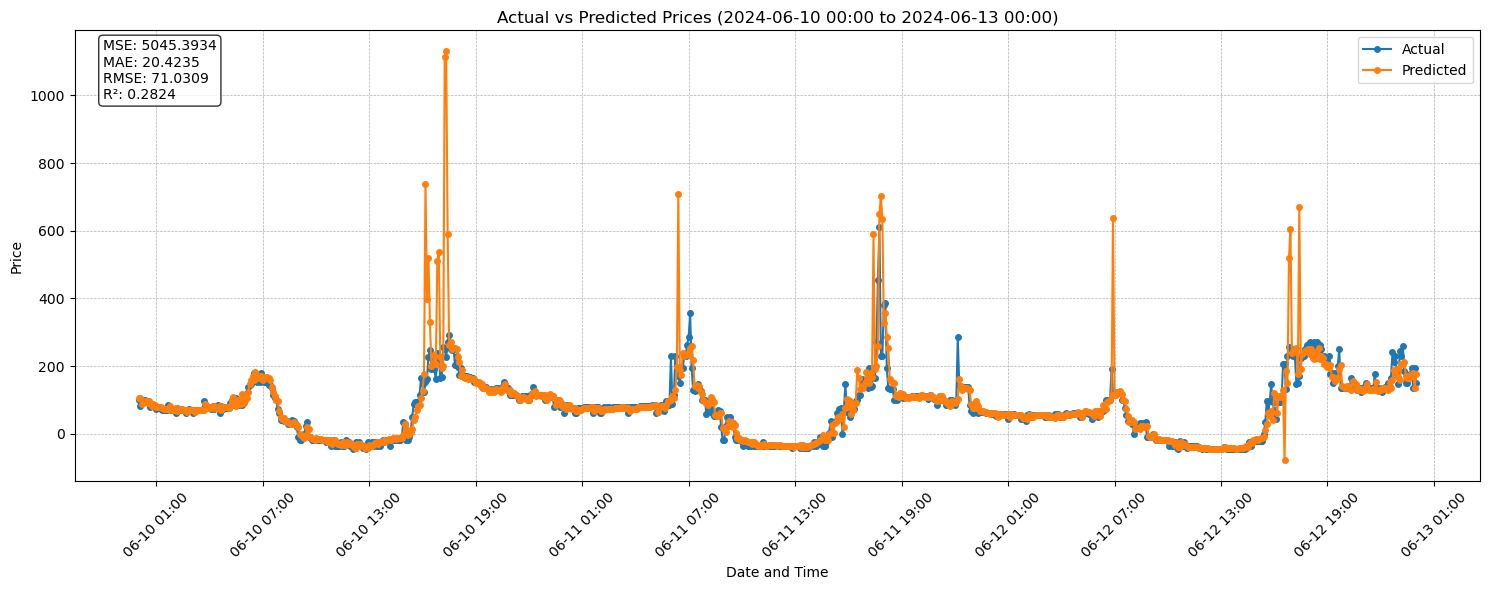

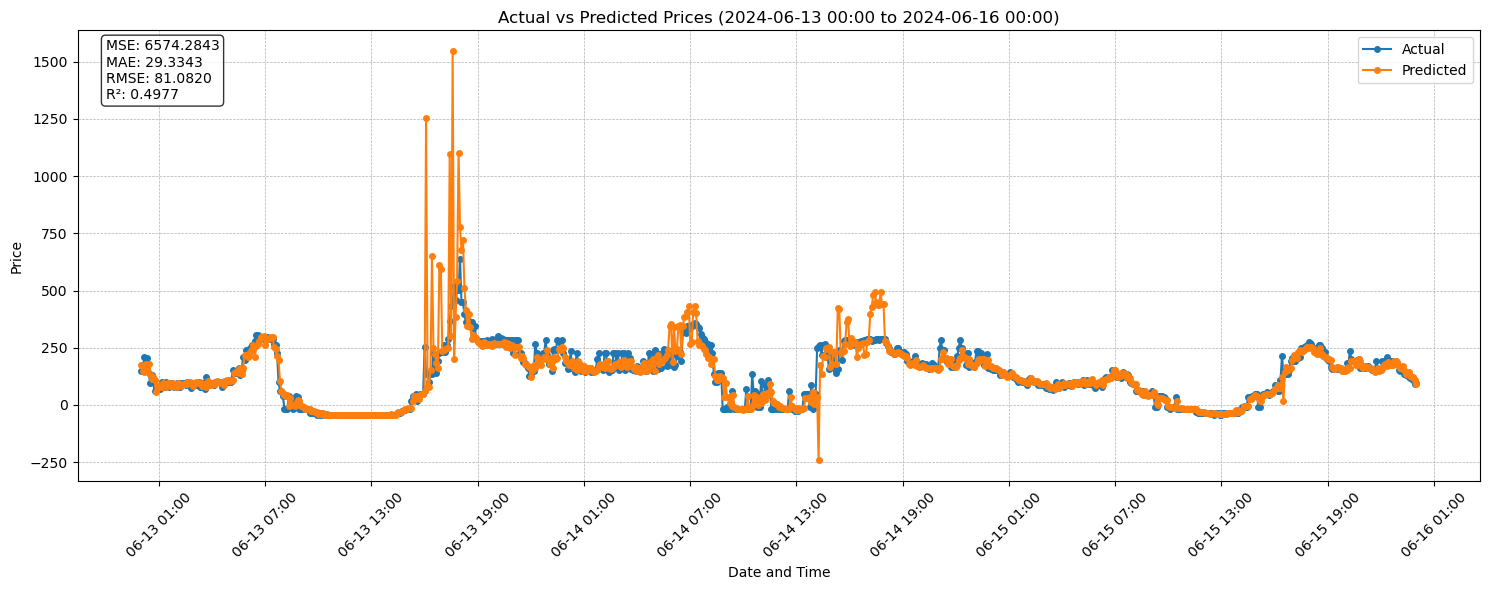

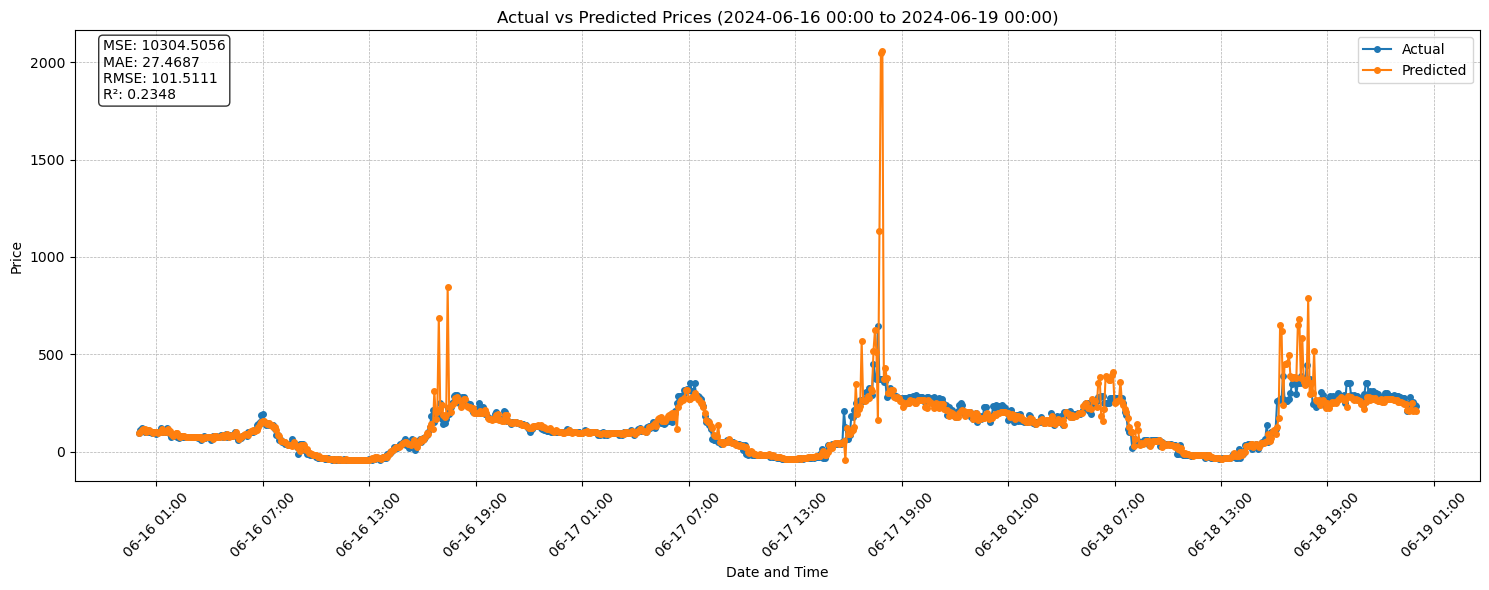

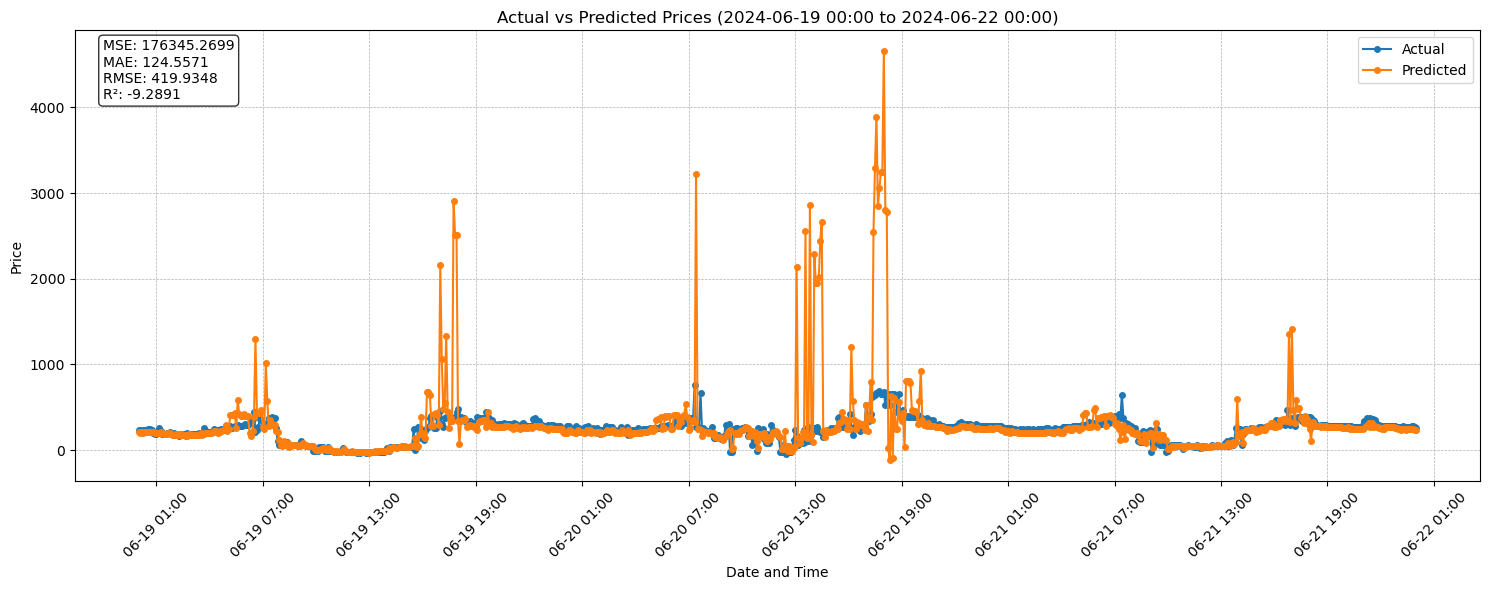

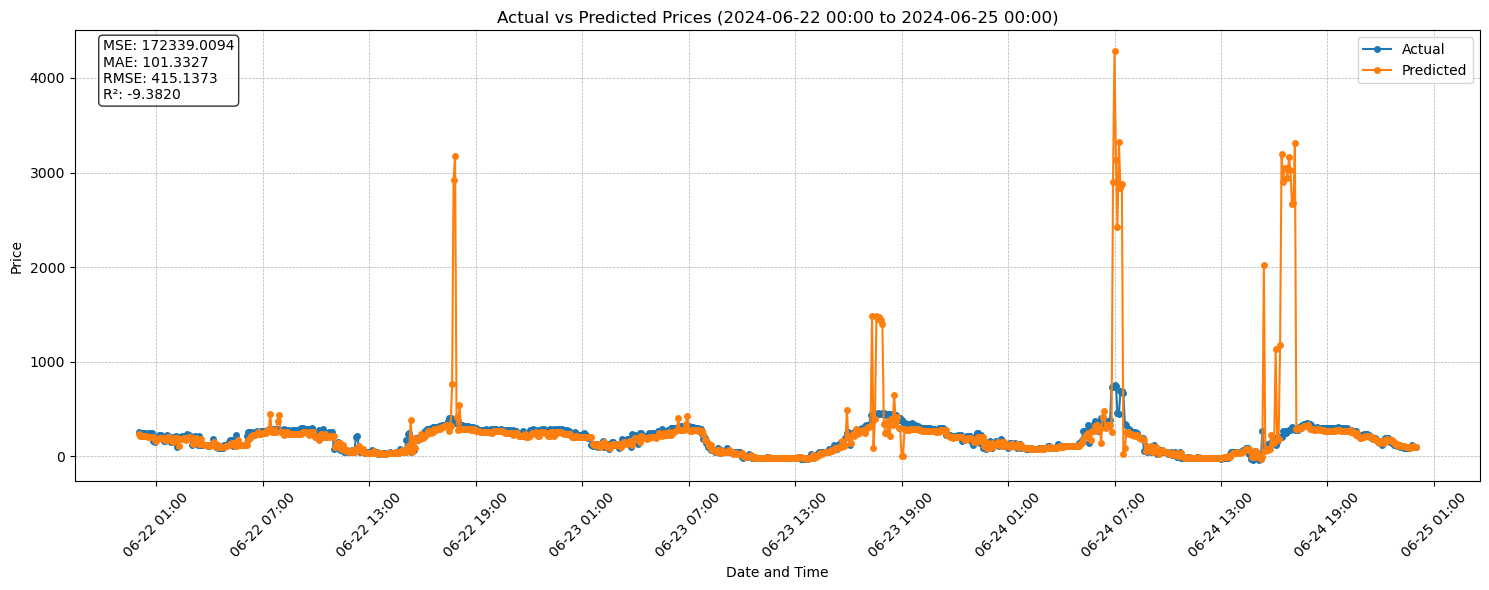

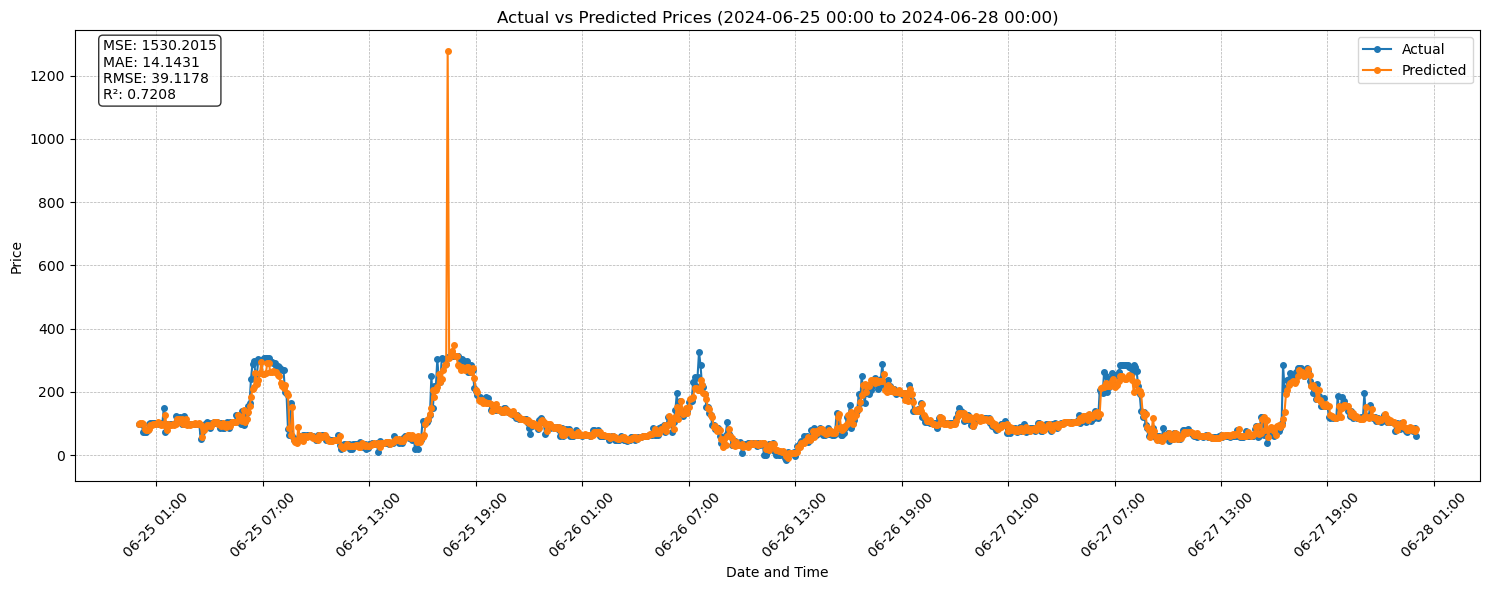

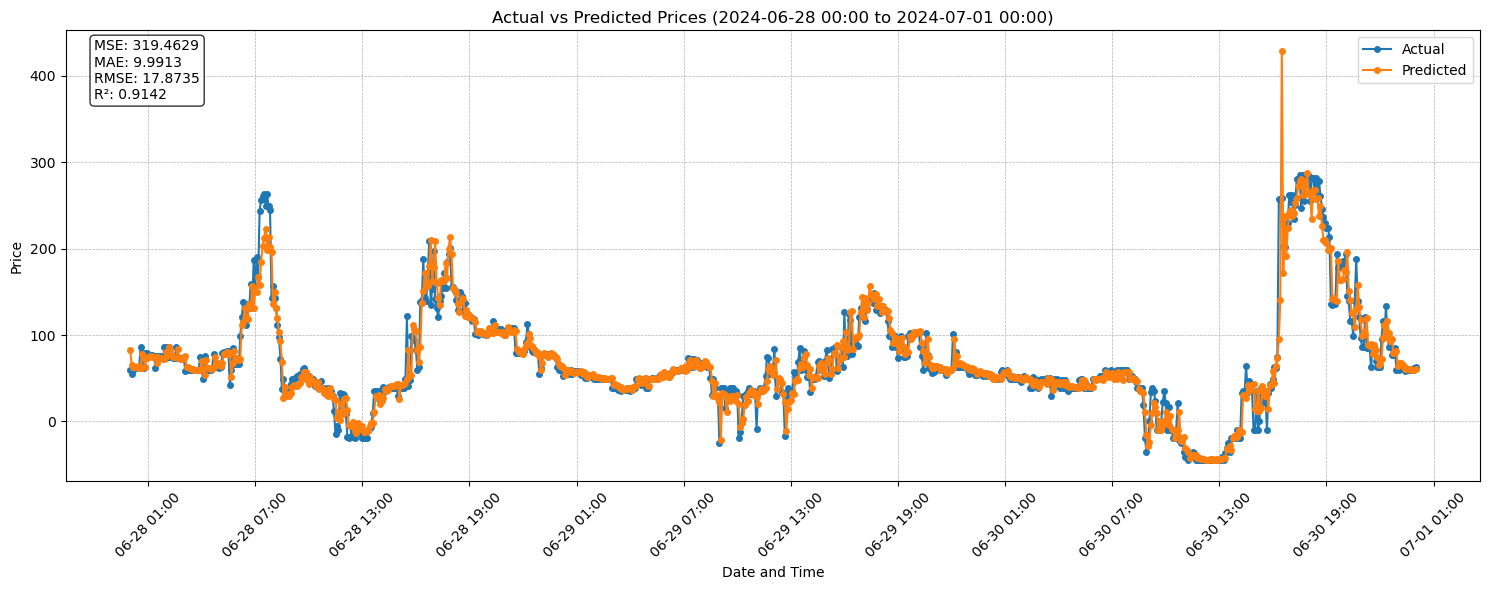

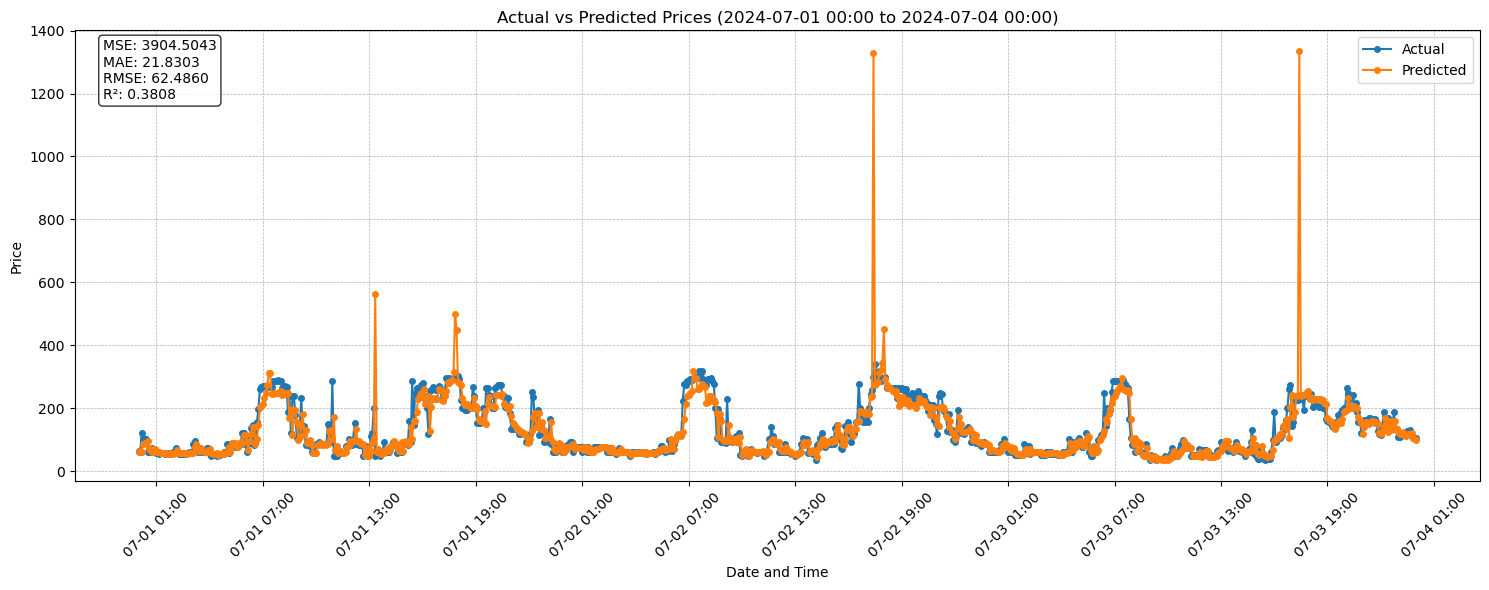

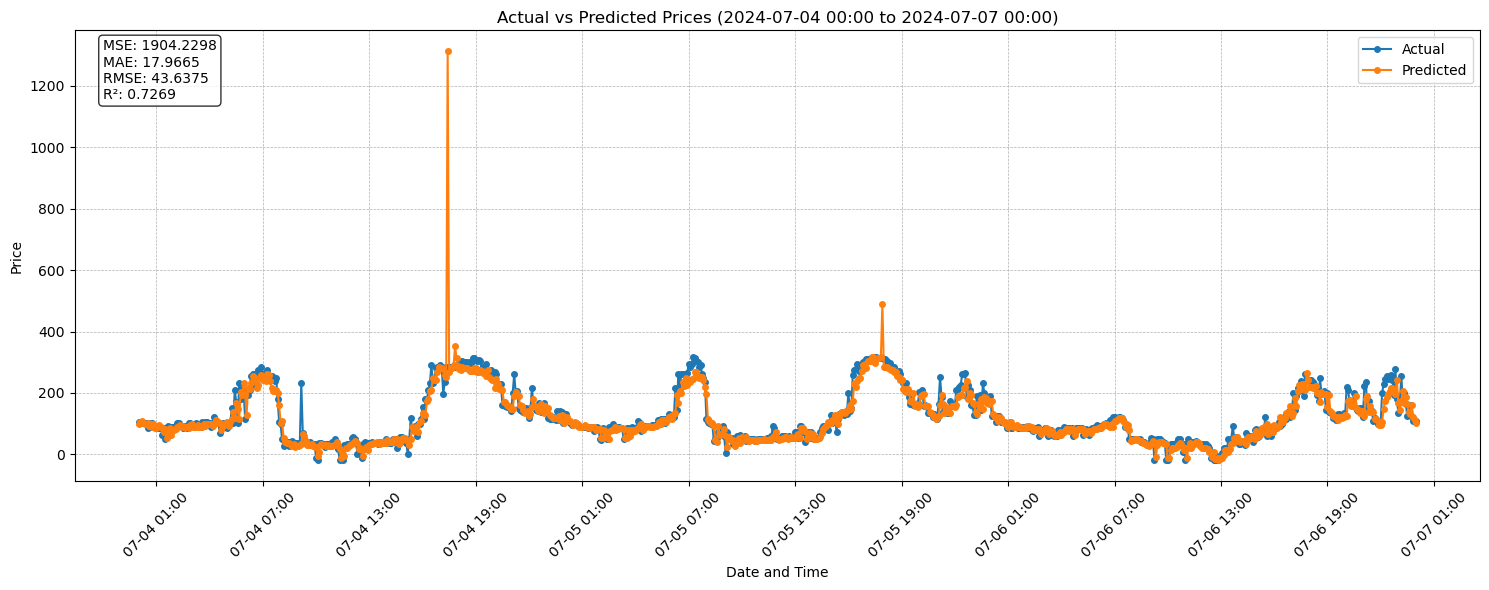

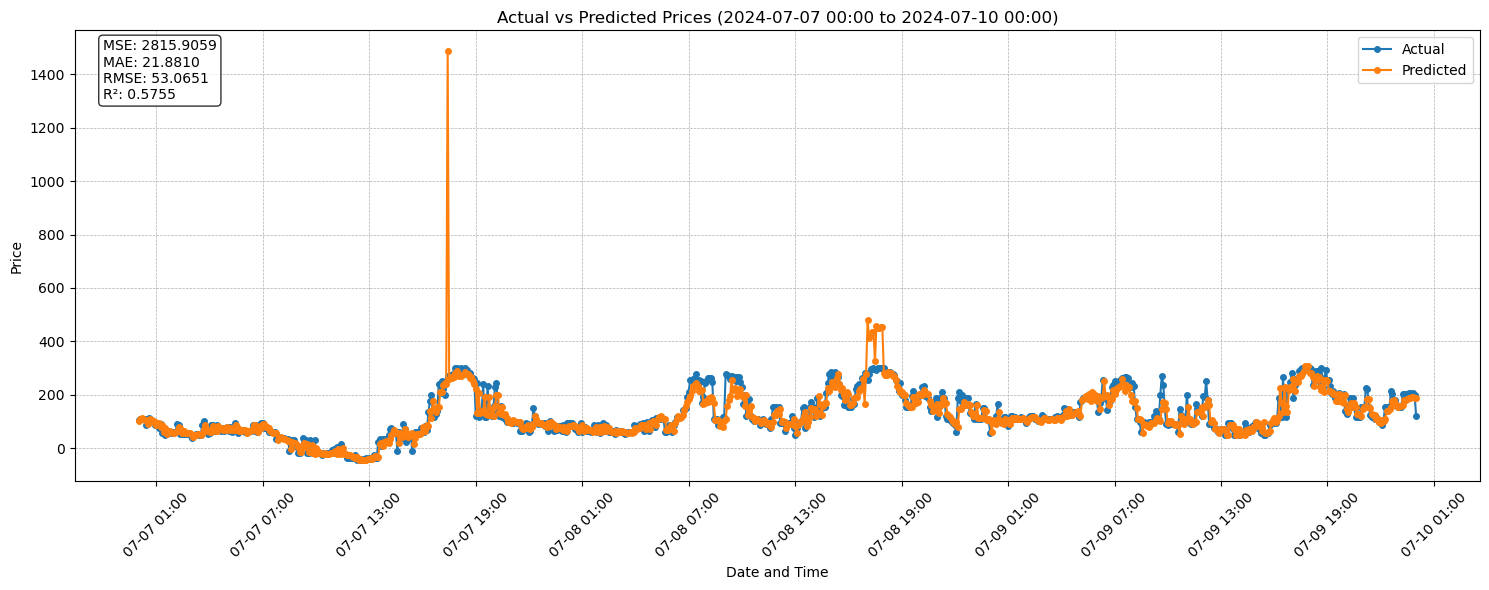

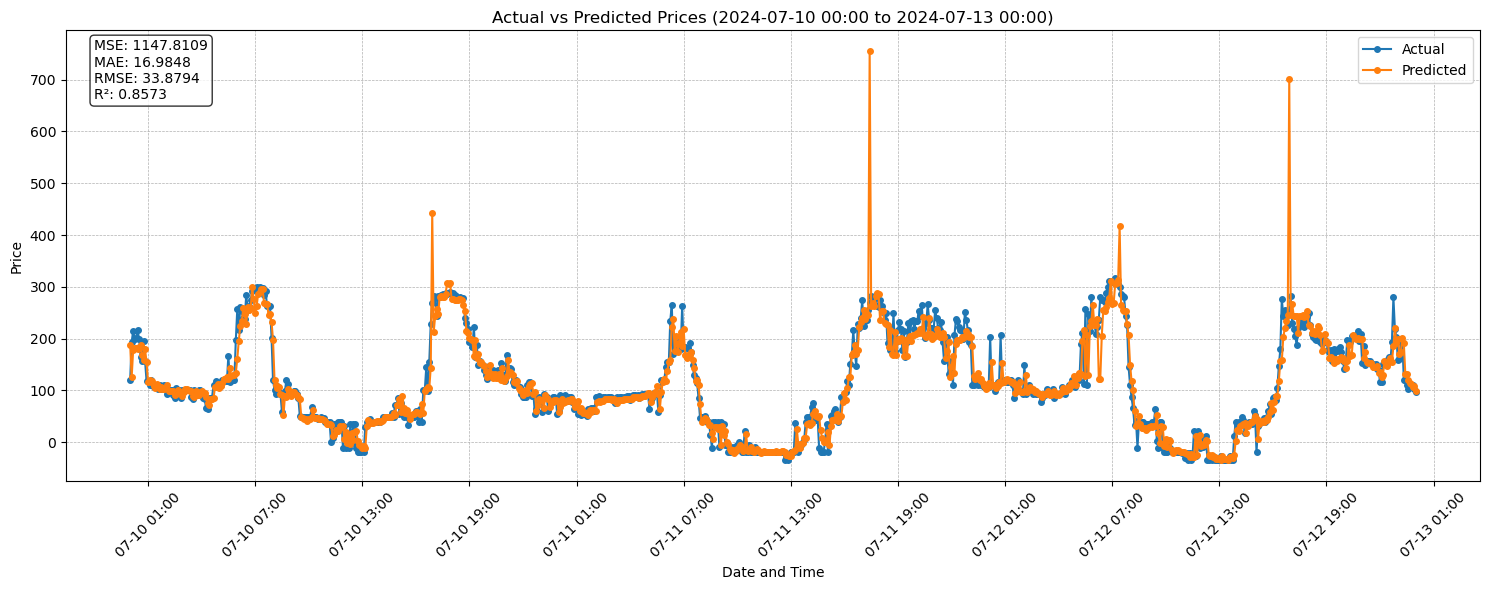

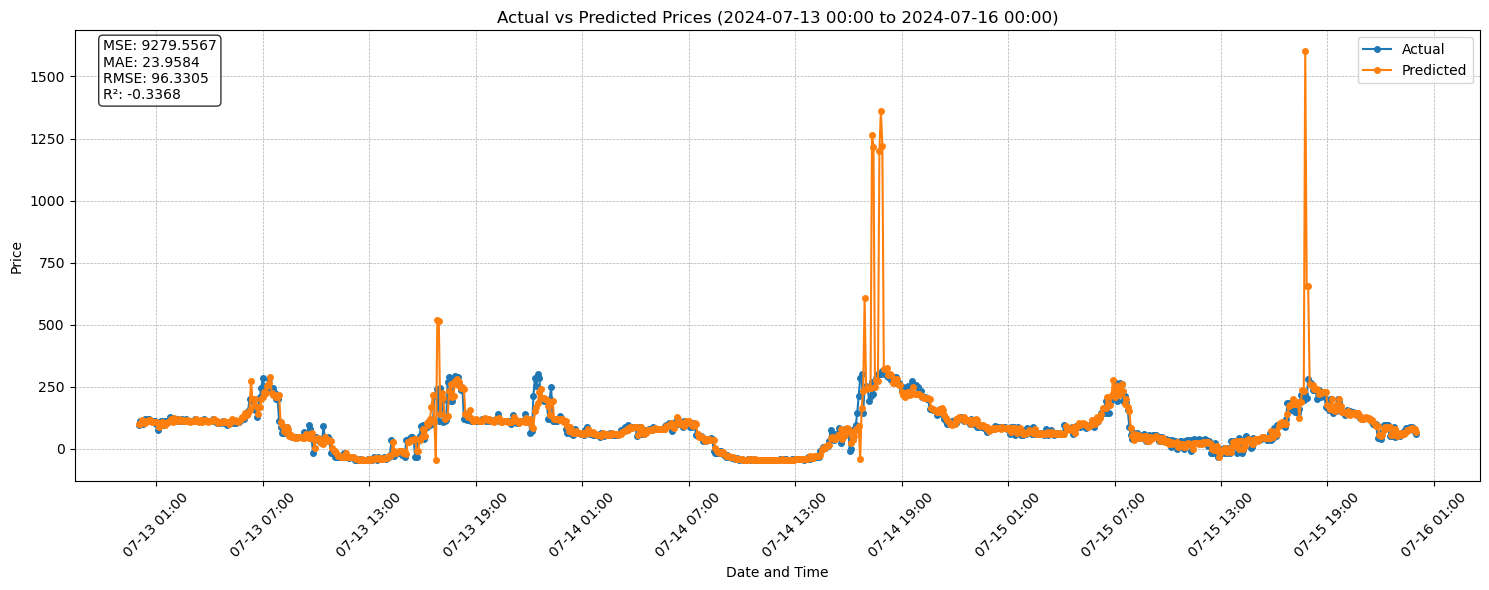

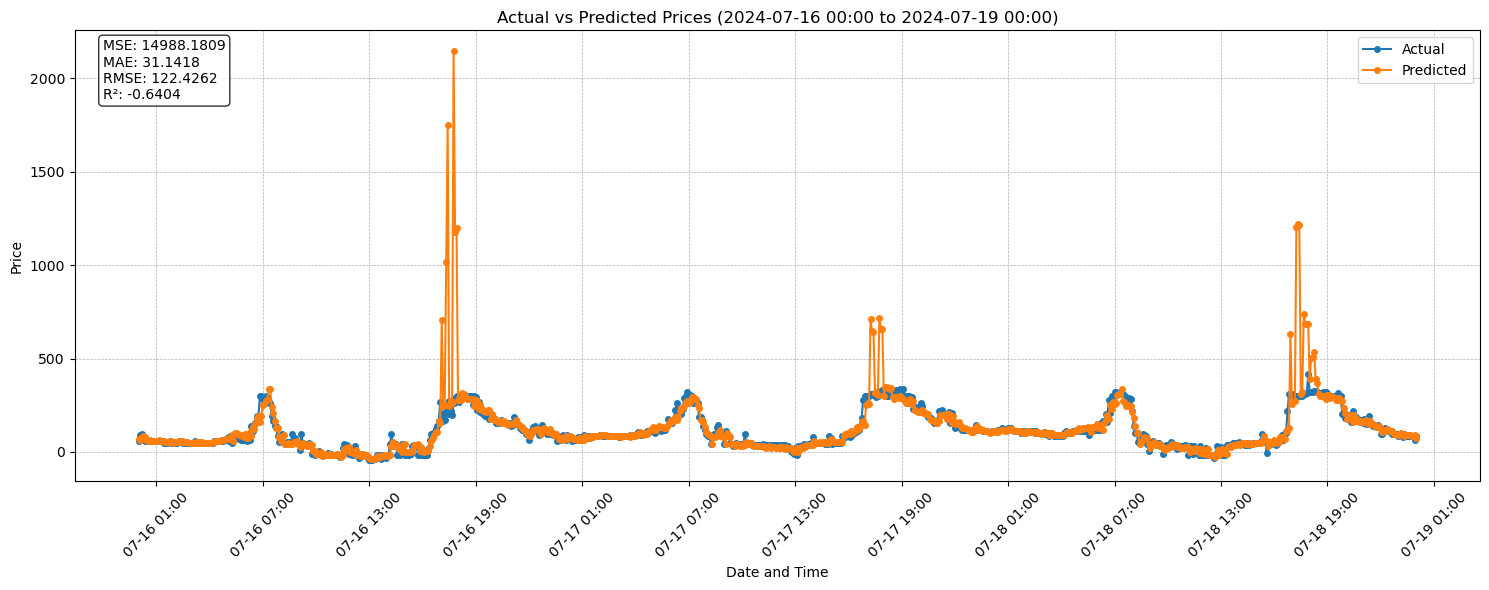

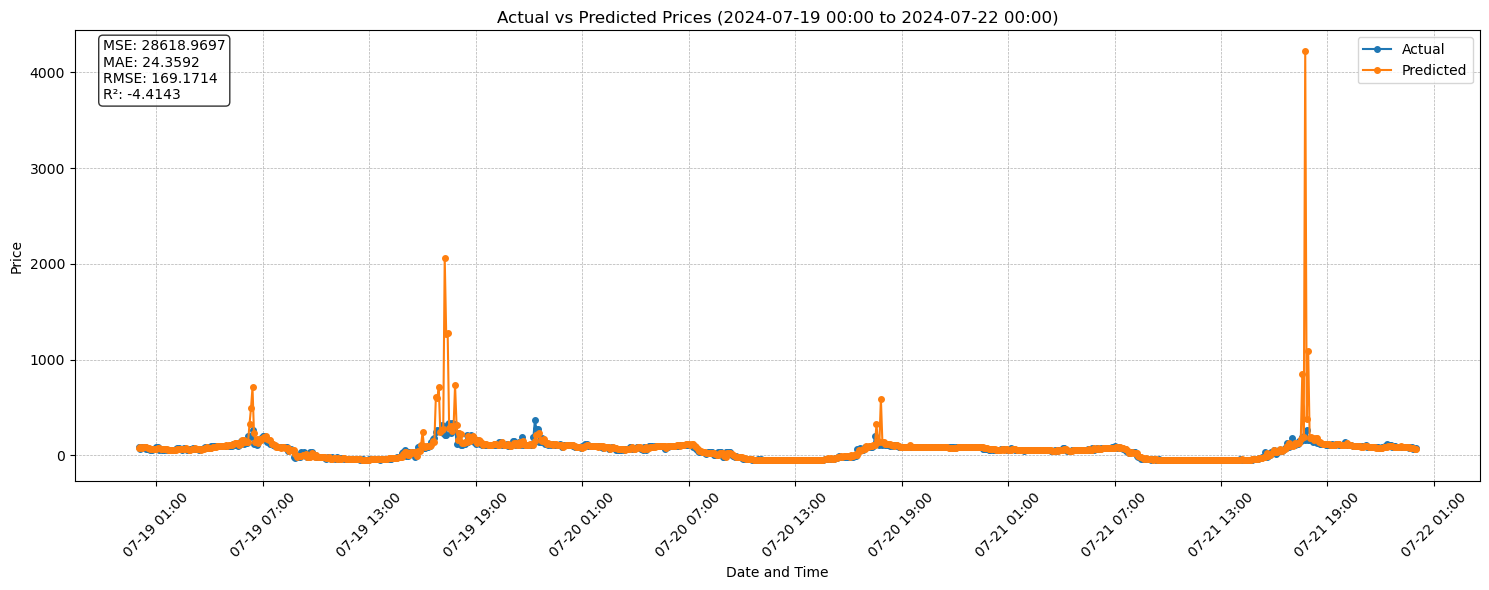

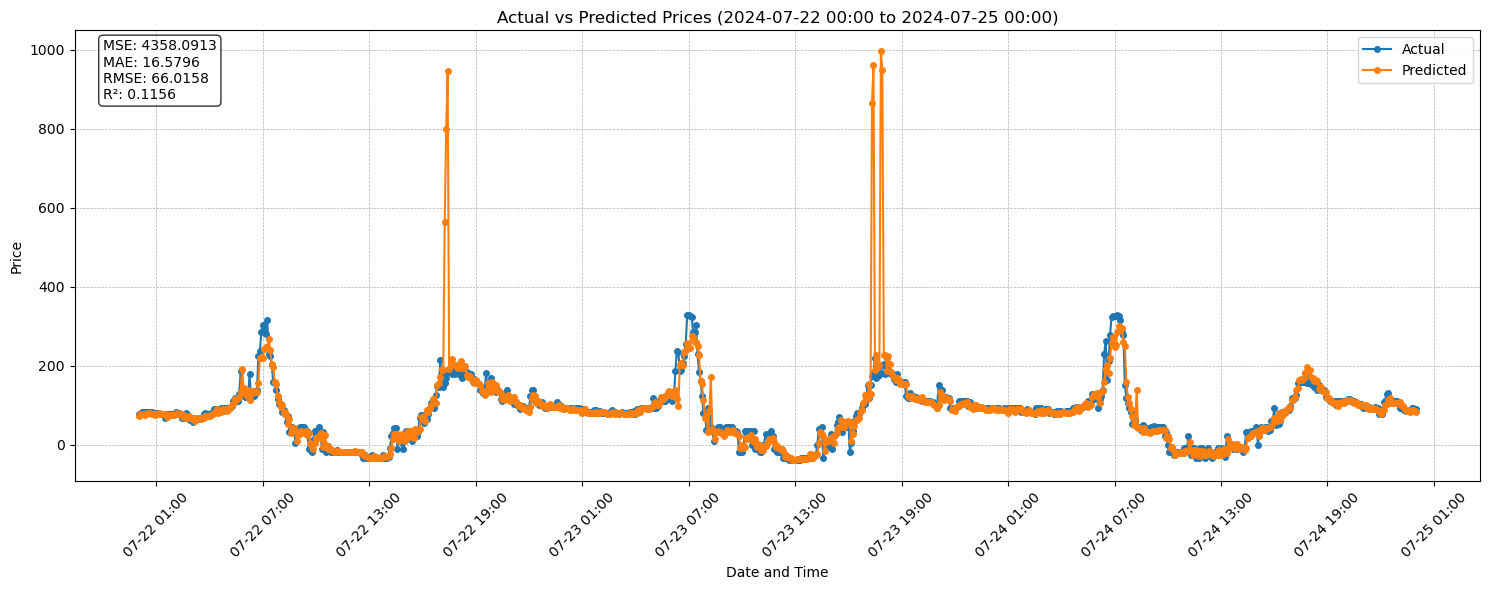

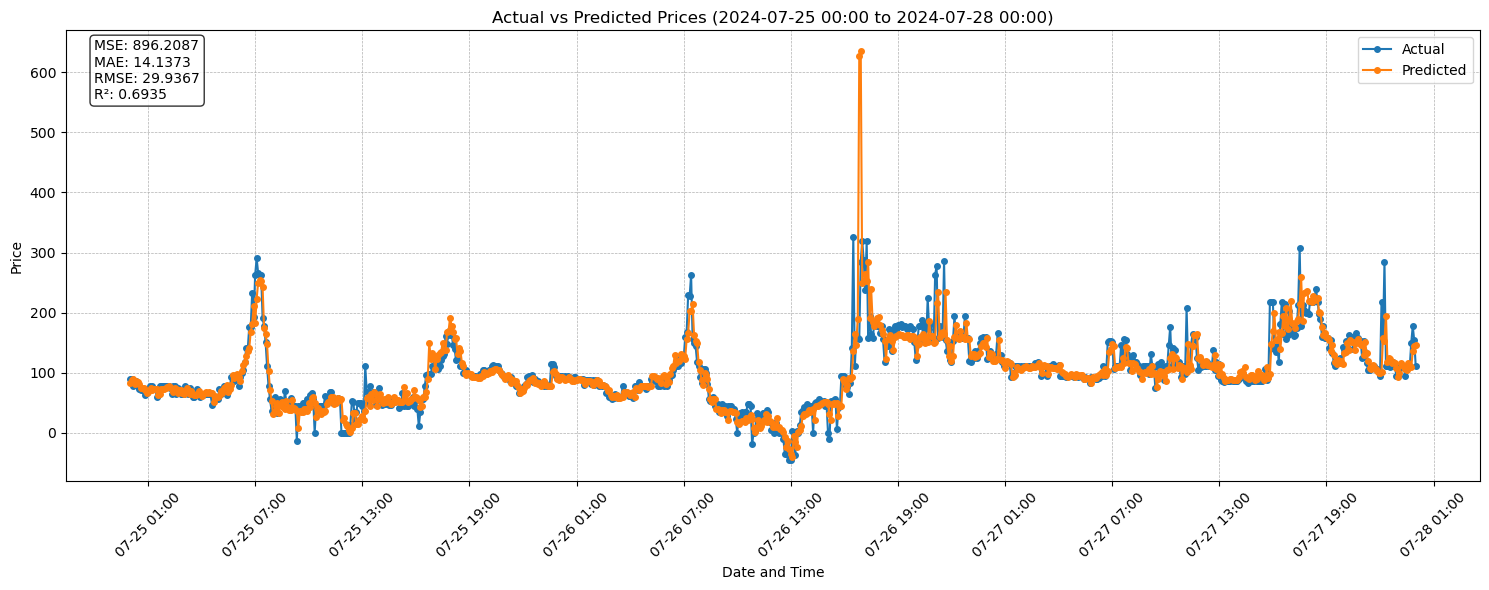

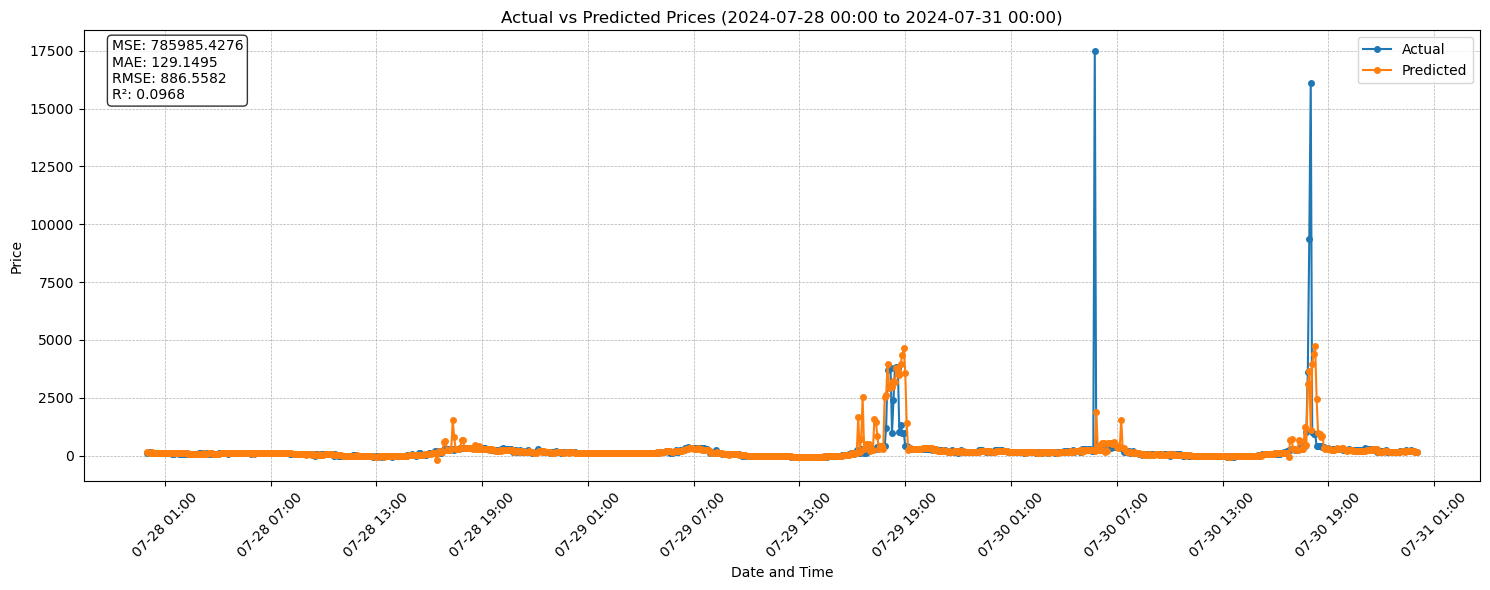

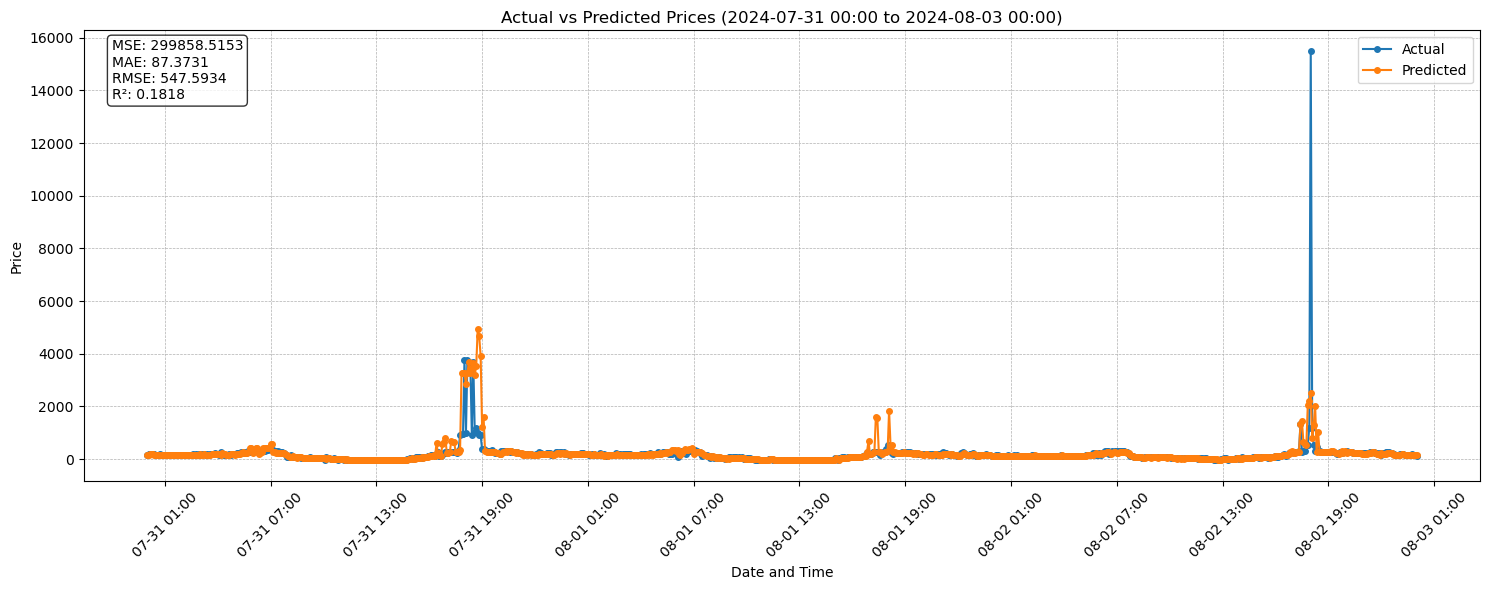

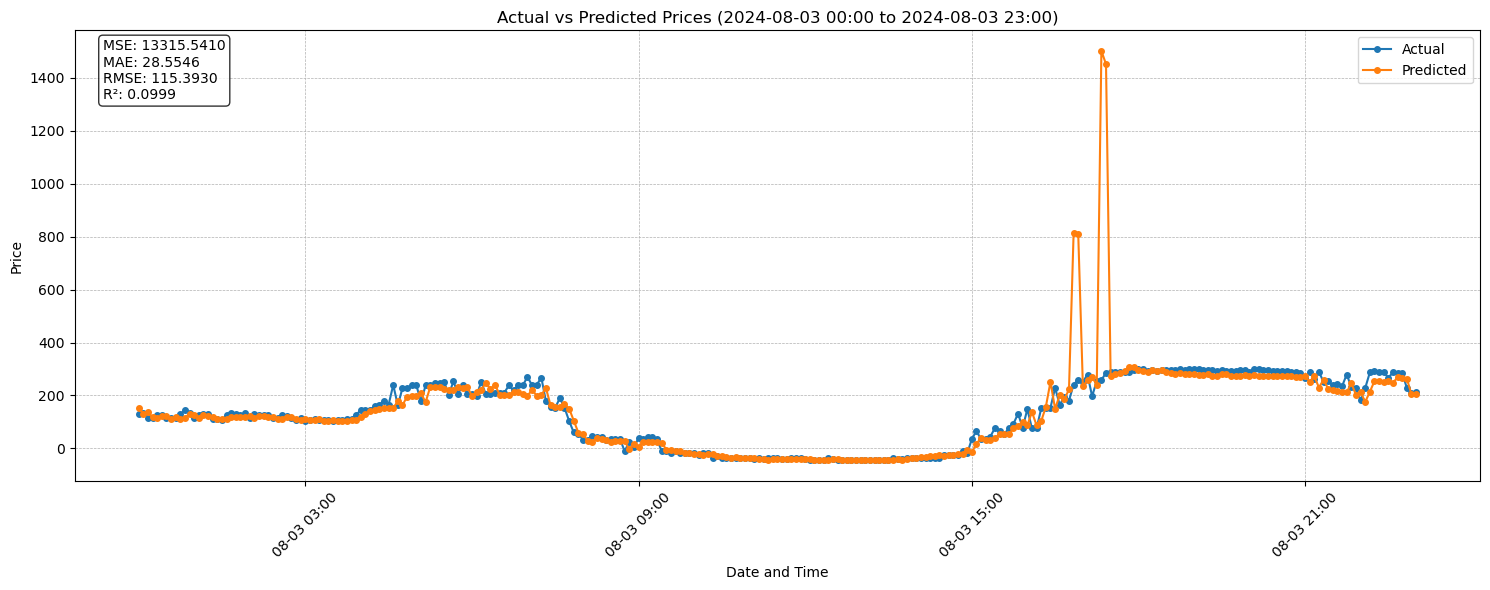

Overall Performance Metrics:
Mean Squared Error: 72886.6938
Mean Absolute Error: 37.9935
Root Mean Squared Error: 269.9754
R-squared Score: -0.0764


In [194]:

import matplotlib.pyplot as plt
from matplotlib.dates import DayLocator, HourLocator, DateFormatter

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


results_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions}, index=y_test.index)

def plot_three_day_comparison(data, start_date, end_date):
    period_data = data.loc[start_date:end_date]
    
    fig, ax = plt.subplots(figsize=(15, 6))
    ax.plot(period_data.index, period_data['Actual'], label='Actual', marker='o', markersize=4)
    ax.plot(period_data.index, period_data['Predicted'], label='Predicted', marker='o', markersize=4)
    
    ax.set_title(f'Actual vs Predicted Prices ({start_date.strftime("%Y-%m-%d %H:%M")} to {end_date.strftime("%Y-%m-%d %H:%M")})')
    ax.set_xlabel('Date and Time')
    ax.set_ylabel('Price')
    ax.legend()
    

    ax.xaxis.set_major_locator(HourLocator(interval=6)) 
    ax.xaxis.set_major_formatter(DateFormatter('%m-%d %H:%M'))
    # ax.xaxis.set_major_locator(DayLocator())  
    # ax.xaxis.set_minor_locator(HourLocator(interval=6))  
    # ax.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))  
    
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
 
    mse = mean_squared_error(period_data['Actual'], period_data['Predicted'])
    mae = mean_absolute_error(period_data['Actual'], period_data['Predicted'])
    rmse = np.sqrt(mse)
    r2 = r2_score(period_data['Actual'], period_data['Predicted'])
    
    metrics_text = f'MSE: {mse:.4f}\nMAE: {mae:.4f}\nRMSE: {rmse:.4f}\nR²: {r2:.4f}'
    plt.text(0.02, 0.98, metrics_text, transform=ax.transAxes, verticalalignment='top', 
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.show()


start_date = results_df.index.min()
end_date = results_df.index.max()


current_date = start_date
while current_date <= end_date:
    period_end = min(current_date + pd.Timedelta(days=3), end_date)
    plot_three_day_comparison(results_df, current_date, period_end)
    current_date += pd.Timedelta(days=3)

mse = mean_squared_error(results_df['Actual'], results_df['Predicted'])
mae = mean_absolute_error(results_df['Actual'], results_df['Predicted'])
rmse = np.sqrt(mse)
r2 = r2_score(results_df['Actual'], results_df['Predicted'])

print(f"Overall Performance Metrics:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared Score: {r2:.4f}")

In [195]:
results_df

,Actual,Predicted
date,,
2024-06-01 00:00:00,149.59,143.938299
2024-06-01 00:05:00,173.01,143.838387
2024-06-01 00:10:00,148.26,162.524523
2024-06-01 00:15:00,155.77,147.822485
2024-06-01 00:20:00,159.50,157.139706
...,...,...
2024-08-03 22:40:00,284.95,268.237320
2024-08-03 22:45:00,284.97,264.551231
2024-08-03 22:50:00,228.01,263.134449


In [196]:
print(results_df[results_df.index == "2024-07-30 05:40:00"])
results_df[results_df.index == "2024-07-30 05:45:00"]


                     Actual  Predicted
date                                  
2024-07-30 05:40:00  187.45  221.46241


,Actual,Predicted
date,,
2024-07-30 05:45:00,17500.0,213.206745


In [197]:
# 找到特定索引的位置
idx = X_test.index.get_loc("2024-07-30 05:40:00")


X_test.iloc[max(0, idx-5): idx+6]




,month,day,weekdays,hour,minute,SMA_4h,SMA_1h,SMA_30min,SMA_2h,Dmemand_diff,is_peak_hour,is_holiday,Demand_lag,Actual_Demand_OPERATIONAL_DEMAND_lag,last_price,rolling_max_price,rolling_min_price,peak_hour_demand_lag,near_max,near_min
date,,,,,,,,,,,,,,,,,,,,
2024-07-30 05:15:00,7,30,1,5,15,160.641667,206.366667,227.526667,178.456667,272.93,0,0,6391.33,6247.0,284.95,299.06,116.39,0.0,True,False
2024-07-30 05:20:00,7,30,1,5,20,163.384375,214.563333,244.645000,184.262083,217.98,0,0,6519.93,6247.0,284.95,299.06,116.39,0.0,True,False
2024-07-30 05:25:00,7,30,1,5,25,165.580833,220.843333,252.981667,188.874167,271.37,0,0,6464.98,6247.0,256.31,299.06,116.39,0.0,False,False
2024-07-30 05:30:00,7,30,1,5,30,167.955000,229.196667,269.285000,193.758750,54.34,0,0,6518.37,6247.0,261.69,299.06,116.39,0.0,False,False
2024-07-30 05:35:00,7,30,1,5,35,170.826667,233.931667,267.036667,200.807917,129.76,0,0,6586.34,6532.0,285.57,299.06,122.69,0.0,True,False
2024-07-30 05:40:00,7,30,1,5,40,172.072083,238.530000,263.496667,204.342083,167.62,0,0,6661.76,6532.0,207.51,299.06,147.32,0.0,False,False
2024-07-30 05:45:00,7,30,1,5,45,172.899583,237.386667,247.246667,205.995417,299.44,0,0,6699.62,6532.0,187.45,299.06,147.32,0.0,False,False
2024-07-30 05:50:00,7,30,1,5,50,534.981667,1680.533333,3116.421667,929.006667,248.03,0,0,6831.44,6532.0,17500.00,17500.00,147.32,0.0,True,False
2024-07-30 05:55:00,7,30,1,5,55,539.261458,1692.488333,3131.995000,937.093333,291.10,0,0,6780.03,6532.0,349.75,17500.00,147.32,0.0,False,False


Hourly Success Rate (sorted from highest to lowest):
hour
20    0.708333
3     0.703125
2     0.701823
1     0.691406
4     0.687500
19    0.680990
21    0.641927
18    0.634115
0     0.632812
23    0.602378
22    0.552083
5     0.535156
12    0.485677
7     0.462240
6     0.458333
17    0.445312
13    0.432292
11    0.408854
10    0.330729
14    0.321615
8     0.319010
16    0.296875
15    0.274740
9     0.261719
Name: is_successful, dtype: float64


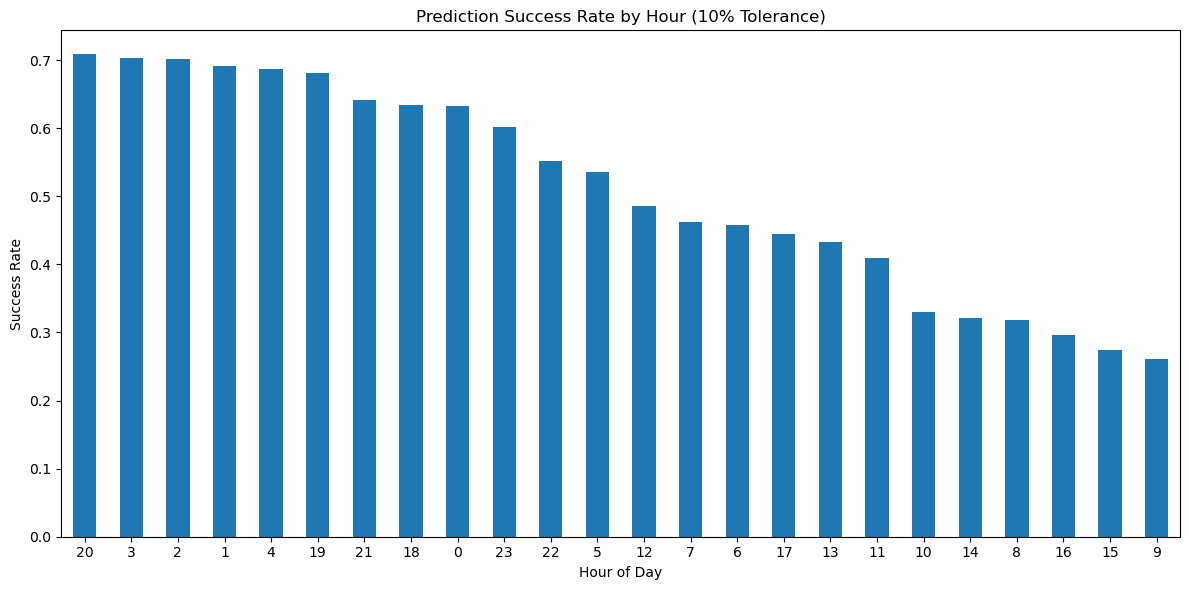

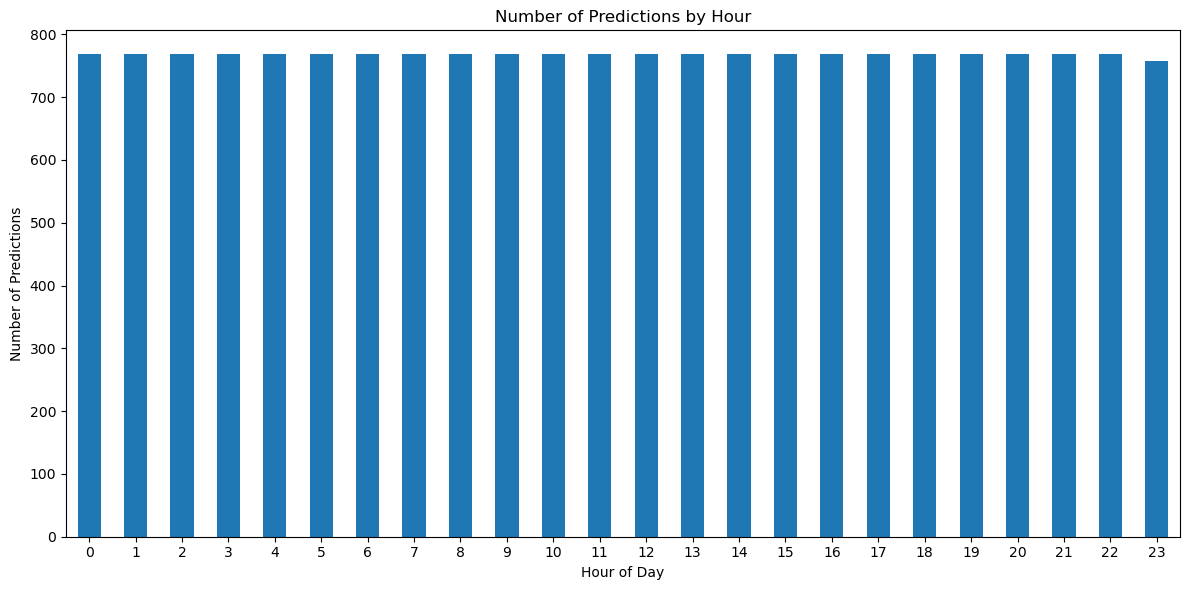


Top 5 hours with highest success rate:
hour
20    0.708333
3     0.703125
2     0.701823
1     0.691406
4     0.687500
Name: is_successful, dtype: float64

Bottom 5 hours with lowest success rate:
hour
9     0.261719
15    0.274740
16    0.296875
8     0.319010
14    0.321615
Name: is_successful, dtype: float64

Overall Success Rate: 51.12%


In [198]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def is_prediction_successful(actual, predicted, tolerance=0.1):
    return abs(predicted - actual) <= abs(actual * tolerance)


results_df['is_successful'] = results_df.apply(lambda row: is_prediction_successful(row['Actual'], row['Predicted']), axis=1)


results_df['hour'] = results_df.index.hour
hourly_success_rate = results_df.groupby('hour')['is_successful'].mean().sort_values(ascending=False)


hourly_prediction_count = results_df.groupby('hour').size()


print("Hourly Success Rate (sorted from highest to lowest):")
print(hourly_success_rate)


plt.figure(figsize=(12, 6))
hourly_success_rate.plot(kind='bar')
plt.title('Prediction Success Rate by Hour (10% Tolerance)')
plt.xlabel('Hour of Day')
plt.ylabel('Success Rate')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 6))
hourly_prediction_count.plot(kind='bar')
plt.title('Number of Predictions by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Predictions')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

top_5_hours = hourly_success_rate.nlargest(5)
bottom_5_hours = hourly_success_rate.nsmallest(5)

print("\nTop 5 hours with highest success rate:")
print(top_5_hours)

print("\nBottom 5 hours with lowest success rate:")
print(bottom_5_hours)

# 計算總體成功率
overall_success_rate = results_df['is_successful'].mean()
print(f"\nOverall Success Rate: {overall_success_rate:.2%}")


# fig, ax1 = plt.subplots(figsize=(15, 6))

# ax1.bar(hourly_success_rate.index, hourly_success_rate.values, alpha=0.7, color='b', label='Success Rate')
# ax1.set_xlabel('Hour of Day')
# ax1.set_ylabel('Success Rate', color='b')
# ax1.tick_params(axis='y', labelcolor='b')

# ax2 = ax1.twinx()
# ax2.plot(hourly_prediction_count.index, hourly_prediction_count.values, color='r', label='Prediction Count')
# ax2.set_ylabel('Number of Predictions', color='r')
# ax2.tick_params(axis='y', labelcolor='r')

# plt.title('Prediction Success Rate and Count by Hour')
# fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
# plt.tight_layout()
# plt.show()

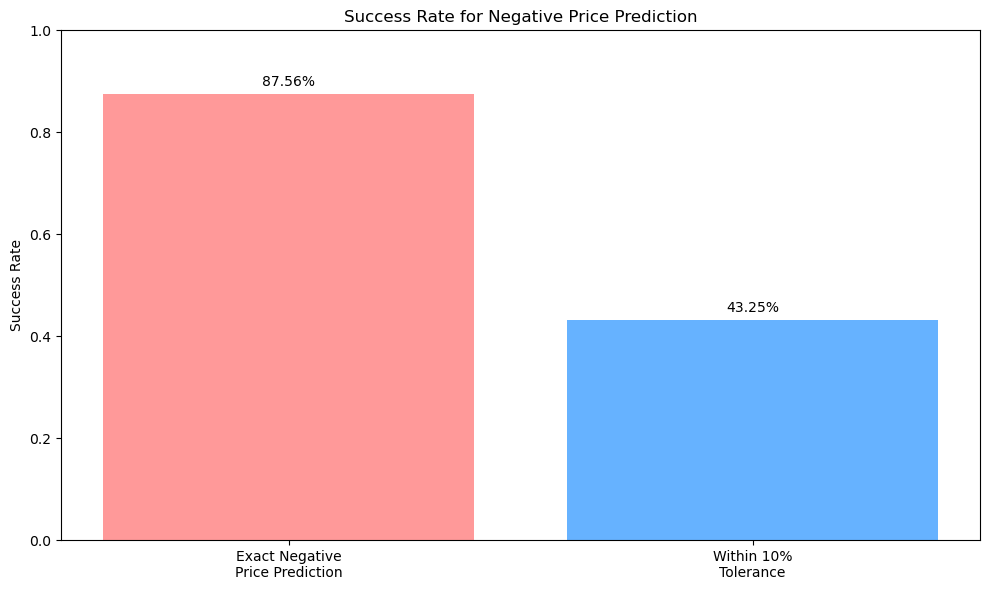

Exact Negative Price Prediction Success Rate: 87.56%
Negative Price Prediction Success Rate (10% Tolerance): 43.25%
Frequency of Negative Prices: 12.79%


In [199]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def is_prediction_successful(actual, predicted, tolerance=0.1):
    return abs(predicted - actual) <= abs(actual * tolerance)


results_df['is_successful'] = results_df.apply(lambda row: is_prediction_successful(row['Actual'], row['Predicted']), axis=1)


def analyze_negative_price_prediction(df):
    negative_price_df = df[df['Actual'] < 0]
    

    exact_success = ((negative_price_df['Predicted'] < 0) & (negative_price_df['Actual'] < 0)).mean()

    tolerance_success = negative_price_df['is_successful'].mean()
    
    return exact_success, tolerance_success


exact_success_rate, tolerance_success_rate = analyze_negative_price_prediction(results_df)


plt.figure(figsize=(10, 6))
success_rates = [exact_success_rate, tolerance_success_rate]
labels = ['Exact Negative\nPrice Prediction', 'Within 10%\nTolerance']
colors = ['#FF9999', '#66B2FF']

plt.bar(labels, success_rates, color=colors)
plt.title('Success Rate for Negative Price Prediction')
plt.ylabel('Success Rate')
plt.ylim(0, 1)  


for i, v in enumerate(success_rates):
    plt.text(i, v + 0.01, f'{v:.2%}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


print(f"Exact Negative Price Prediction Success Rate: {exact_success_rate:.2%}")
print(f"Negative Price Prediction Success Rate (10% Tolerance): {tolerance_success_rate:.2%}")


negative_price_frequency = (results_df['Actual'] < 0).mean()
print(f"Frequency of Negative Prices: {negative_price_frequency:.2%}")

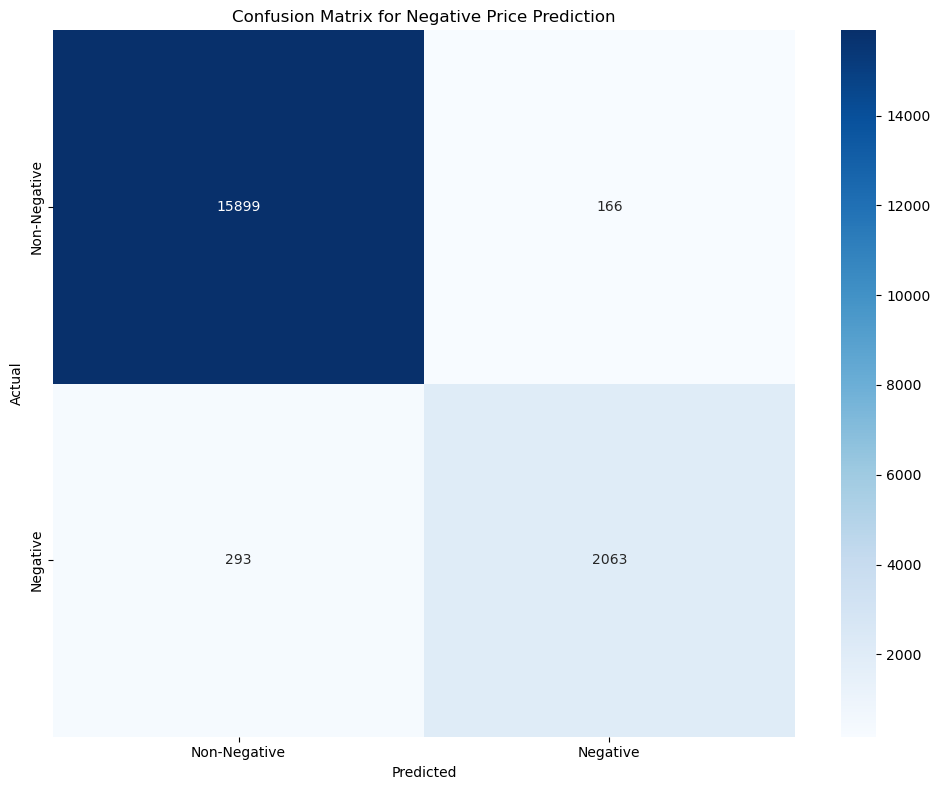

Classification Report for Negative Price Prediction:
              precision    recall  f1-score   support

Non-Negative       0.98      0.99      0.99     16065
    Negative       0.93      0.88      0.90      2356

    accuracy                           0.98     18421
   macro avg       0.95      0.93      0.94     18421
weighted avg       0.97      0.98      0.97     18421


Accuracy: 0.9751
Precision: 0.9255
Recall: 0.8756
F1 Score: 0.8999
Frequency of Negative Prices: 12.79%


In [200]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def analyze_negative_price_prediction(df):
    # 將實際值和預測值轉換為二元類別（負價為1，非負價為0）
    actual_binary = (df['Actual'] < 0).astype(int)
    predicted_binary = (df['Predicted'] < 0).astype(int)
    
    # 計算混淆矩陣
    cm = confusion_matrix(actual_binary, predicted_binary)
    
    # 計算分類報告
    report = classification_report(actual_binary, predicted_binary, target_names=['Non-Negative', 'Negative'])
    
    return cm, report

# 假設 results_df 已經包含 'Actual' 和 'Predicted' 列
cm, report = analyze_negative_price_prediction(results_df)

# 繪製混淆矩陣
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Negative Price Prediction')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.xticks([0.5, 1.5], ['Non-Negative', 'Negative'])
plt.yticks([0.5, 1.5], ['Non-Negative', 'Negative'])
plt.tight_layout()
plt.show()

# 打印分類報告
print("Classification Report for Negative Price Prediction:")
print(report)

# 計算並打印其他指標
tn, fp, fn, tp = cm.ravel()
accuracy = (tp + tn) / (tp + tn + fp + fn)
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

# 計算負價的頻率
negative_price_frequency = (results_df['Actual'] < 0).mean()
print(f"Frequency of Negative Prices: {negative_price_frequency:.2%}")


False Positives (Predicted Negative, Actually Non-Negative) by hour of day:
date
8      5
9     23
10    21
11    22
12    16
13    27
14    27
15    16
16     6
18     2
19     1
dtype: int64

False Positives (Predicted Negative, Actually Non-Negative) by day of week:
date
Friday       25
Monday       21
Saturday     19
Sunday       30
Thursday     26
Tuesday      22
Wednesday    23
dtype: int64

False Positives (Predicted Negative, Actually Non-Negative) by month:
date
August     8
July      88
June      70
dtype: int64


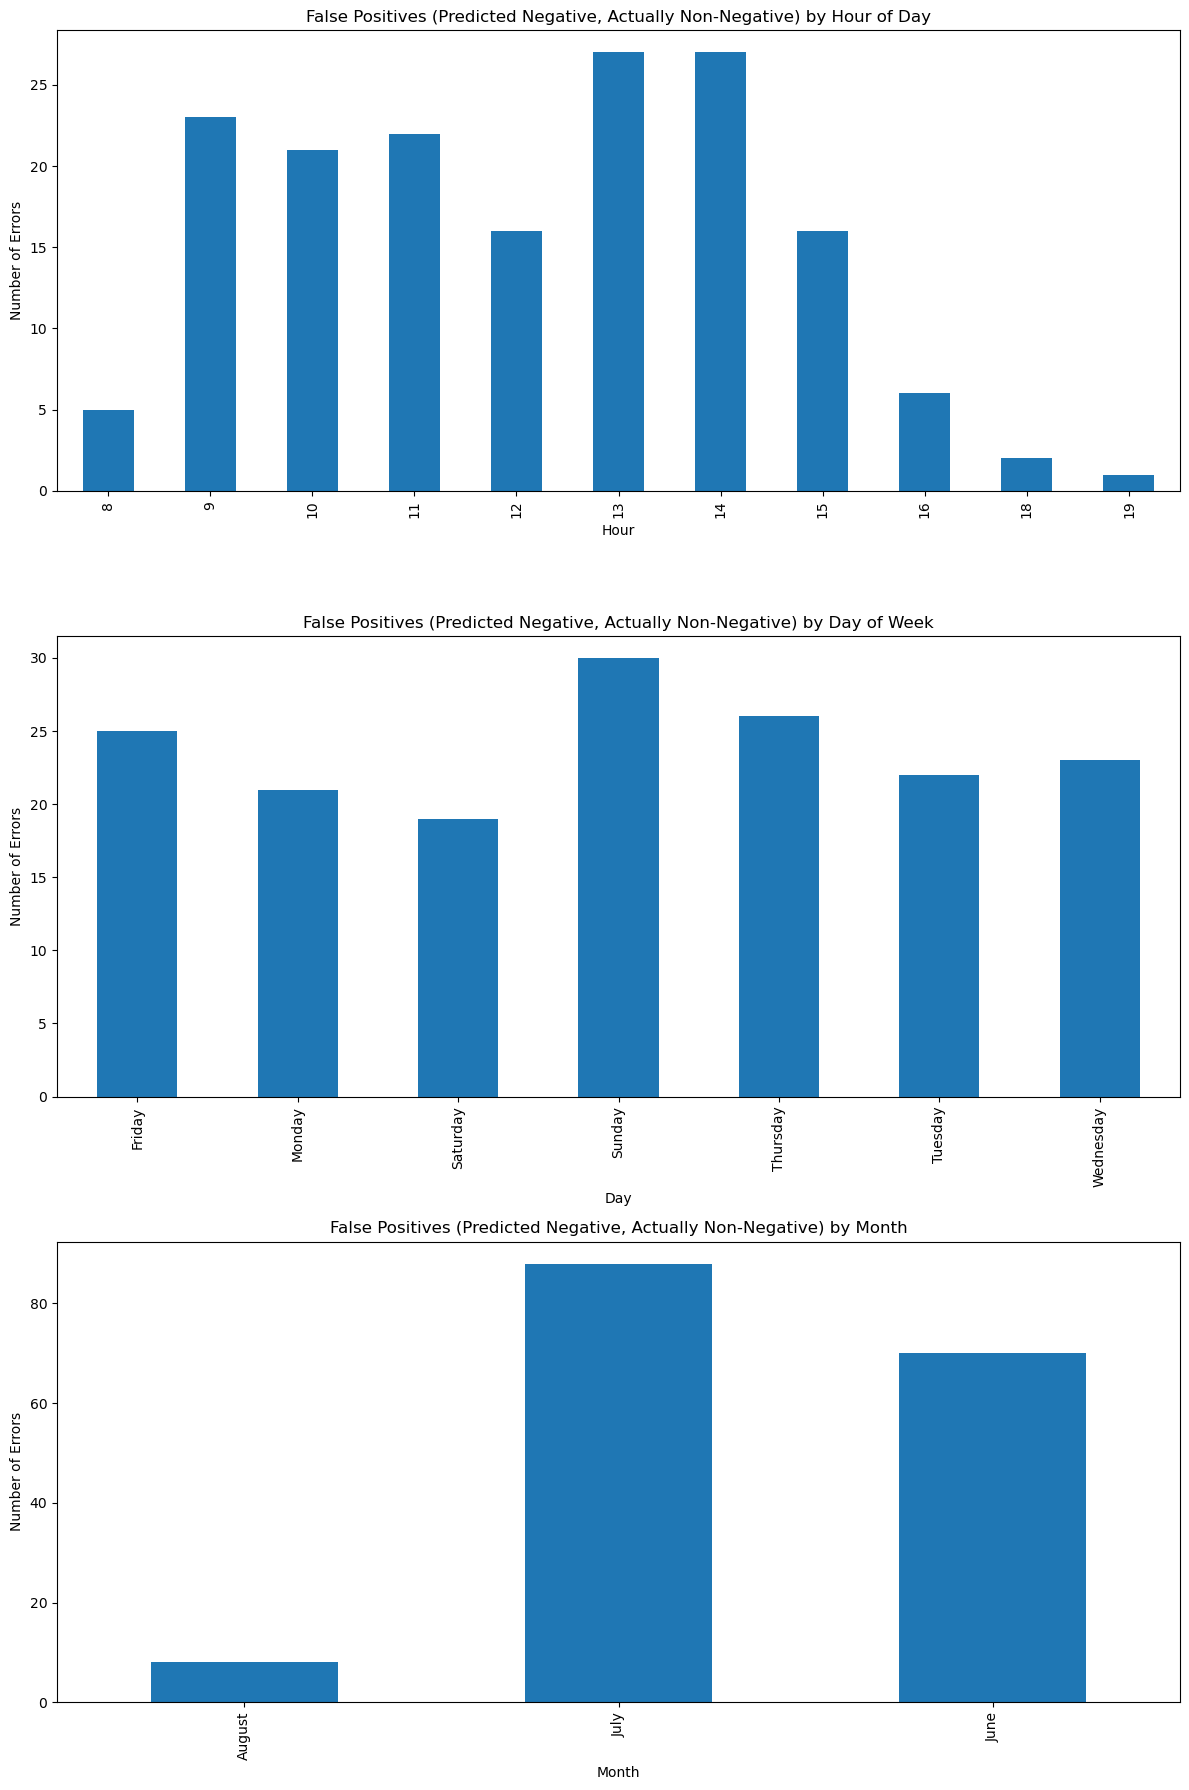


False Negatives (Predicted Non-Negative, Actually Negative) by hour of day:
date
8     29
9     63
10    53
11    35
12    30
13    16
14    26
15    31
16    10
dtype: int64

False Negatives (Predicted Non-Negative, Actually Negative) by day of week:
date
Friday       55
Monday       32
Saturday     31
Sunday       40
Thursday     50
Tuesday      42
Wednesday    43
dtype: int64

False Negatives (Predicted Non-Negative, Actually Negative) by month:
date
August     10
July      142
June      141
dtype: int64


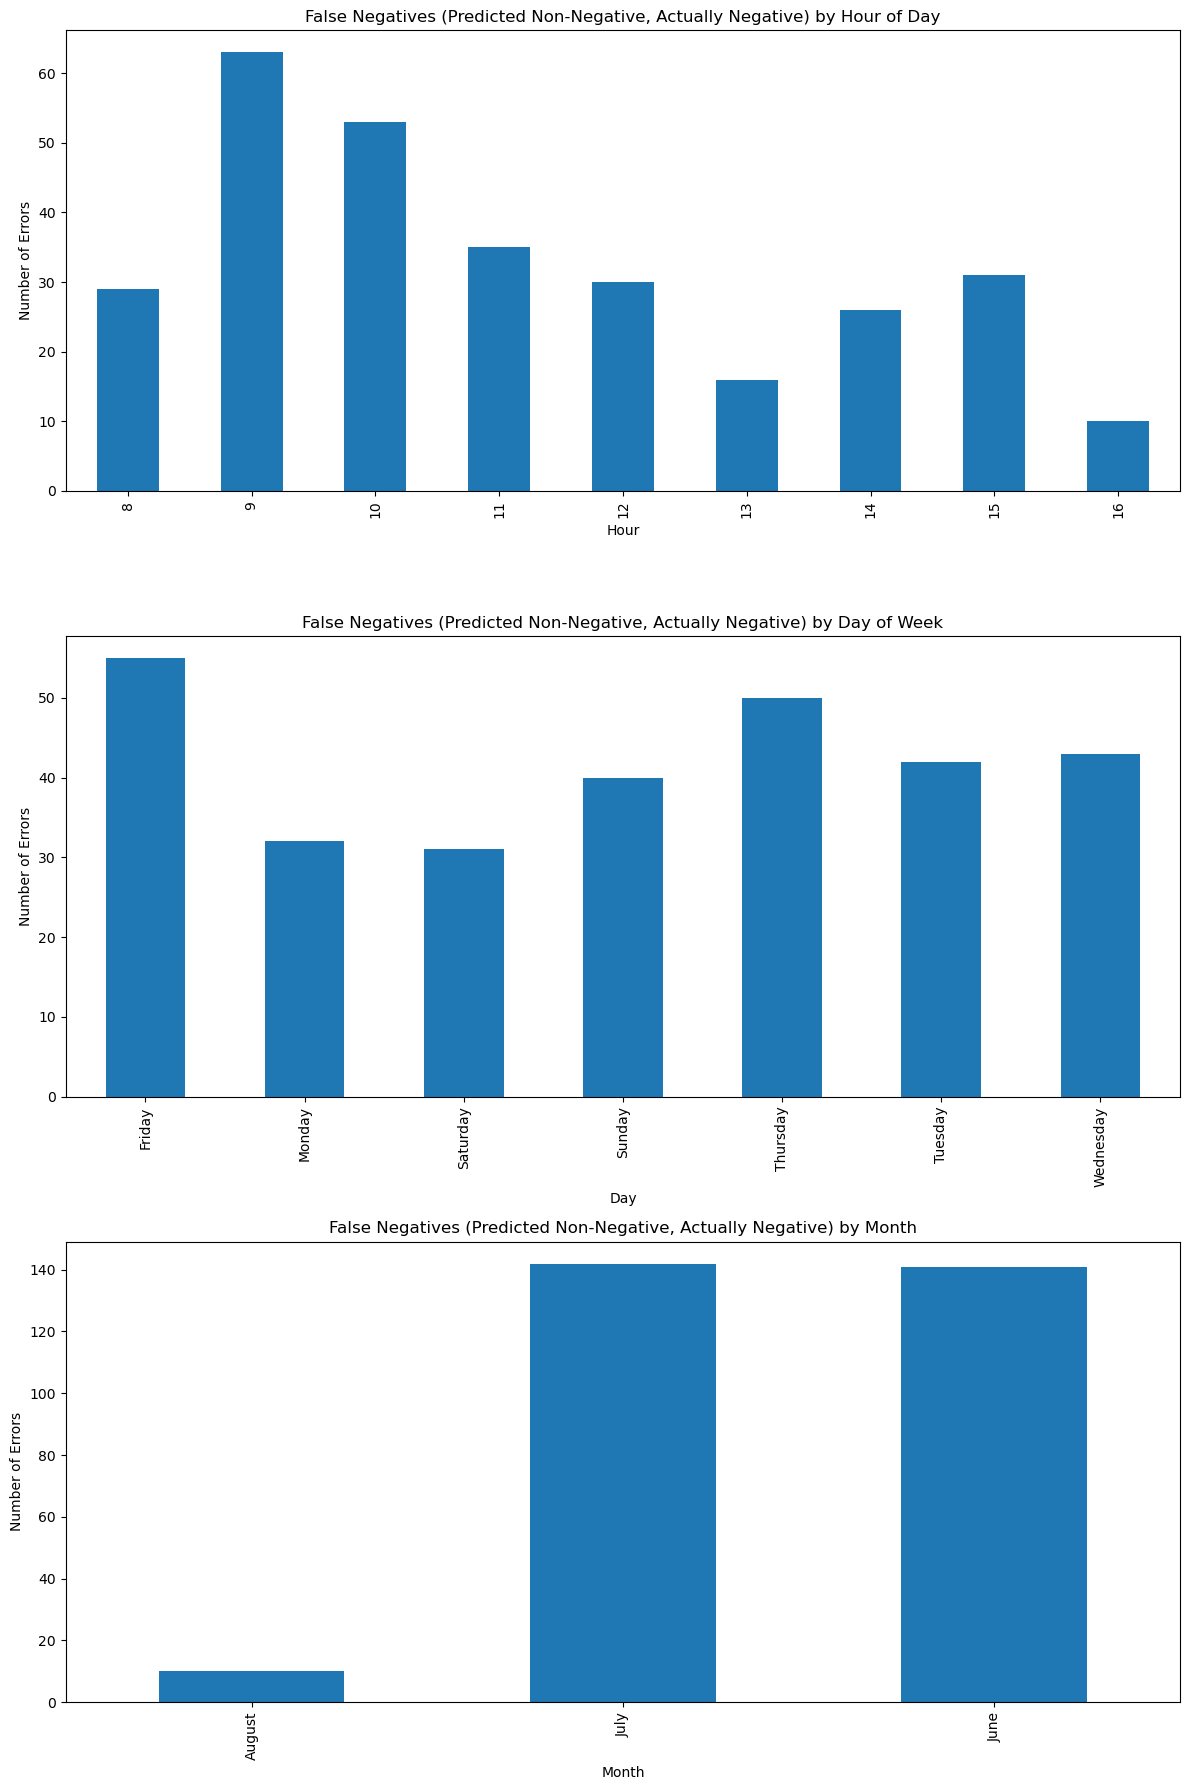


Details of False Positive samples:
                     Actual  Predicted
date                                  
2024-06-02 14:30:00   32.18  -6.103977
2024-06-03 14:15:00    0.00  -0.224099
2024-06-04 13:45:00   34.75  -4.885059
2024-06-04 15:10:00   59.85  -8.776518
2024-06-04 16:05:00  256.01 -12.707795
...                     ...        ...
2024-08-02 13:00:00    6.33 -12.560366
2024-08-02 13:05:00   27.73  -1.151042
2024-08-02 13:40:00    5.42  -6.411025
2024-08-03 08:50:00   24.48  -2.635546
2024-08-03 15:00:00   34.75 -15.024298

[166 rows x 2 columns]

Details of False Negative samples:
                     Actual  Predicted
date                                  
2024-06-02 09:15:00  -18.89  22.480212
2024-06-03 10:00:00  -18.89  25.197853
2024-06-03 10:05:00  -18.89   4.075974
2024-06-03 10:10:00  -25.40   3.112034
2024-06-04 09:55:00  -10.50  31.547282
...                     ...        ...
2024-08-02 12:15:00   -0.82  14.382496
2024-08-02 12:20:00  -10.00   0.059370
2024-08

In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_negative_price_prediction_errors(df):
    # 將實際值和預測值轉換為二元類別（負價為1，非負價為0）
    df['Actual_Binary'] = (df['Actual'] < 0).astype(int)
    df['Predicted_Binary'] = (df['Predicted'] < 0).astype(int)
    
    # 識別錯誤預測
    df['Misclassified'] = df['Actual_Binary'] != df['Predicted_Binary']
    
    # 提取錯誤預測的樣本
    errors = df[df['Misclassified']]
    
    # 分類錯誤類型
    false_positives = errors[(errors['Actual_Binary'] == 0) & (errors['Predicted_Binary'] == 1)]
    false_negatives = errors[(errors['Actual_Binary'] == 1) & (errors['Predicted_Binary'] == 0)]
    
    # 時間統計函數
    def time_statistics(data, error_type):
        by_hour = data.groupby(data.index.hour).size()
        by_day = data.groupby(data.index.day_name()).size()
        by_month = data.groupby(data.index.month_name()).size()
        
        print(f"\n{error_type} by hour of day:")
        print(by_hour)
        print(f"\n{error_type} by day of week:")
        print(by_day)
        print(f"\n{error_type} by month:")
        print(by_month)
        
        # 繪製圖表
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))
        
        by_hour.plot(kind='bar', ax=ax1)
        ax1.set_title(f'{error_type} by Hour of Day')
        ax1.set_xlabel('Hour')
        ax1.set_ylabel('Number of Errors')
        
        by_day.plot(kind='bar', ax=ax2)
        ax2.set_title(f'{error_type} by Day of Week')
        ax2.set_xlabel('Day')
        ax2.set_ylabel('Number of Errors')
        
        by_month.plot(kind='bar', ax=ax3)
        ax3.set_title(f'{error_type} by Month')
        ax3.set_xlabel('Month')
        ax3.set_ylabel('Number of Errors')
        
        plt.tight_layout()
        plt.show()
    
    # 進行時間統計
    time_statistics(false_positives, "False Positives (Predicted Negative, Actually Non-Negative)")
    time_statistics(false_negatives, "False Negatives (Predicted Non-Negative, Actually Negative)")
    
    # 打印錯誤樣本的詳細信息
    print("\nDetails of False Positive samples:")
    print(false_positives[['Actual', 'Predicted']])
    
    print("\nDetails of False Negative samples:")
    print(false_negatives[['Actual', 'Predicted']])
    
    return false_positives, false_negatives

# 假設 results_df 已經包含 'Actual' 和 'Predicted' 列，且索引是時間戳
false_positives, false_negatives = analyze_negative_price_prediction_errors(results_df)

# 打印總體錯誤統計
print(f"\nTotal number of False Positives: {len(false_positives)}")
print(f"Total number of False Negatives: {len(false_negatives)}")